# Notebook 6: Aprendizaje por refuerzo - Programación dinámica

En este notebook nos familizarizaremos con [Gym](https://www.gymlibrary.dev/), una librería de Python para simular problemas que se pueden resolver utilizando aprendizaje por refuerzo.
Además, desarrollaremos algunos métodos de control basados en programación dinámica.

## Gym
Gym es una herramienta para desarrollar y comparar algoritmos de aprendizaje por refuerzo. Facilita la simulación de interacciones de un agente con entornos muy diversos.

Para utilizar OpenGym, el primer paso es importar la librería. Una vez hecho, podremos crear un entorno que nos permita simular el problema que deseemos de entre los muchos disponibles.

En esta práctica utilizaremos un entorno muy sencillo que simula un *GridWorld*, es decir, un mundo compuesto por casillas por las que el agente podrá desplazarse. En particular, cargaremos el entorno `MiniGrid-Empty-5x5-v0`.

In [1]:
# Si los paquetes no están instalados, hay que ejecutar estas líneas:
#!pip install gymnasium[classic-control]
#!pip install minigrid 
import gymnasium as gym
import minigrid
import numpy as np
env = gym.make('MiniGrid-Empty-5x5-v0', render_mode='rgb_array')

El método `gym.make` devuelve un objeto de tipo entorno que nos ofrece, entre otros, los siguientes métodos y propiedades:
 - `reset`: Devuelve el entorno a su estado original
 - `actions`: Muestra una lista de las acciones disponibles
 - `max_steps`: Fija el número máximo de acciones que puede realizar el agente en cada episodio
 - `render`: Devuelve una imagen donde aparece representada la situación actual
 - `step(accion)`: Ejecuta una acción y actualiza el entorno en consecuencia
 
El objetivo del agente en este problema es alcanzar la meta, representada por una casilla verde. El agente aparece representado como una flecha roja que refleja su posición y orientación.

['left', 'right', 'forward', 'pickup', 'drop', 'toggle', 'done']


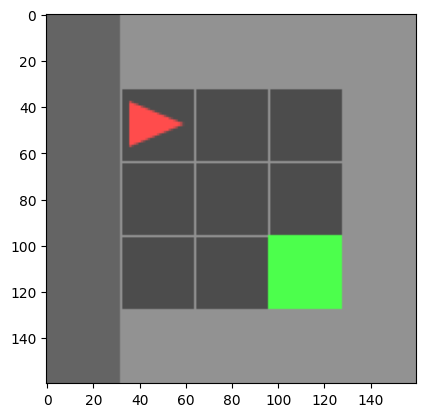

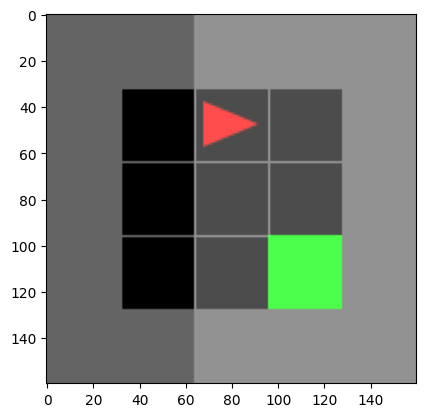

Ellipsis

In [31]:
# Muestra las acciones disponibles
acciones = env.get_wrapper_attr('actions')
print([a.name for a in acciones])

# Resetea el entorno
env.reset()

# Muestra el entorno en su estado inicial
import matplotlib.pyplot as plt

def muestra_entorno(env:gym.Env) -> None:
    im = plt.imshow(env.render())
    plt.show()
muestra_entorno(env)

# TODO: Ejecuta la acción forward (puedes referirte a la acción i-ésima como acciones(i) o como acciones.nombre) y muestra el entorno de nuevo
env.step(2)
muestra_entorno(env)

# TODO: Prueba a ver cómo afectan las distintas acciones al entorno
...

El método [`step(acción)`](https://gymnasium.farama.org/api/env/#gymnasium.Env.step) devuelve cinco valores:
 - Observación: Representa lo que puede percibir el agente del entorno en su estado actual
 - Recompensa: Indica el valor de la señal de recompensa para la ejecución de la acción aplicada en el estado en que se aplicó.
 - Terminated: Valor booleano que indica si se ha terminado el episodio
 - Truncated: Valor booleano que indica si el episodio ha alcanzado el número máximo de pasos
 - Info: Información adicional
 
De cara a aprender una política, debemos buscar una manera de representar los estados. Habitualmente, el agente se basaría en sus observaciones para generar una representación del estado. Sin embargo, para este problema en particular, vamos a utilizar una representación del estado más sencilla que la observación que puede hacer el agente. Esta labor de representación del estado la llevaría a cabo el **intérprete** en el esquema habitual de un problema de aprendizaje por refuerzo.
![Esquema de aprendizaje por refuerzo](https://raw.githubusercontent.com/eirasf/GCED-AA3/94f123b1ad1ec5686d86b8ce7c8cda757a26ca02/lab4/img/Reinforcement_learning_diagram.svg)

El intérprete identificará el estado con un vector de tres componentes que indicarán, respectivamente, la columna, fila y orientación del agente. Las filas/columnas se numerarán del 0 al 2 (de arriba a abajo y derecha a izquierda) y la orientación podrá tomar los siguientes valores:
 - 0 $\rightarrow$ derecha
 - 1 $\rightarrow$ abajo
 - 2 $\rightarrow$ izquierda
 - 3 $\rightarrow$ arriba
 
El entorno de este problema nos da acceso directo a dos variables que serán de utilidad:
 - `agent_pos`: Indica la casilla en la que está el agente. Las casillas del tablero están numeradas del 1 al 3, por lo que será necesario adaptar dicha numeración.
 - `agent_dir`: Indica la orientación del agente usando el código descrito en el párrafo anterior.
 
 Puedes acceder a estos valores como `env.get_wrapper_attr('agent_pos')` y `env.get_wrapper_attr('agent_dir')` respectivamente.
Creemos una función que haga las labores de intérprete y devuelva la codificación del estado actual del entorno:

In [35]:
from collections import namedtuple

# Representaremos los estados como tuplas con los siguientes campos con nombre:
#  - x: Representa la columna en que se encuentra el agente. La columna visitable más a la izquierda será la 0
#  - y: Representa la fila en que se encuentra el agente. La fila visitable más arriba será la 0
#  - dir: Representa la dirección en que apunta el agente. Respetaremos el código numérico indicado por agent_dir
Estado = namedtuple('Estado', ['x', 'y', 'dir'])

def get_estado(env:gym.Env) -> Estado:
    # TODO - Completa la función
    x, y = env.get_wrapper_attr('agent_pos')
    dir = env.get_wrapper_attr('agent_dir')
    return Estado(x=x-1, y=y-1, dir=dir) 

env.reset()

# COMPROBACIÓN
estado_actual = get_estado(env)
assert estado_actual.x == 0, f'El estado inmediatamente después de resetear debe indicar x=0 y el tuyo indica {estado_actual.x}'
assert estado_actual.y == 0, f'El estado inmediatamente después de resetear debe indicar y=0 y el tuyo indica {estado_actual.y}'
assert estado_actual.dir == 0, f'El estado inmediatamente después de resetear debe indicar dir=0 y el tuyo indica {estado_actual.dir}'

### Simulación de un episodio con política aleatoria

Ahora que sabemos manejar el entorno, vamos a probar qué tal funciona una política aleatoria.

Crea un bucle que simule un episodio completo siguiendo una política aleatoria, es decir, que aplique una acción aleatoria hasta que el entorno nos indique que el episodio ha acabado. Puedes obtener una acción aleatoria llamando a `env.action_space.sample()`.

Muestra el entorno tras aplicar cada acción. Además muestra un mensaje que indique:
 - Qué número de paso se ha ejecutado
 - El nombre de la acción aplicada
 - El estado resultante
 - La recompensa obtenida en ese paso
 - Si ha terminado la ejecución

In [54]:
env.step(2)[2]

False

Max steps modificado: inf
Paso 0, accion 1, x: 2, y 2, dir 2


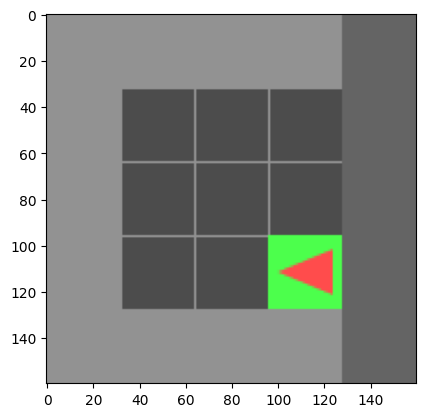

Paso 1, accion 5, x: 2, y 2, dir 2


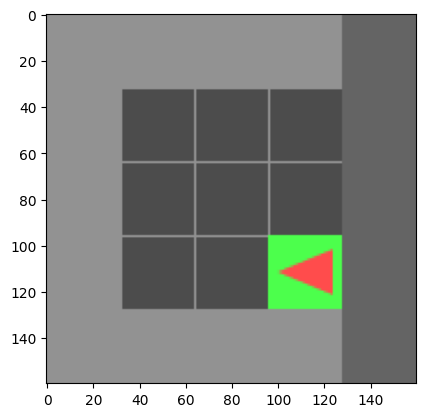

Paso 2, accion 5, x: 2, y 2, dir 2


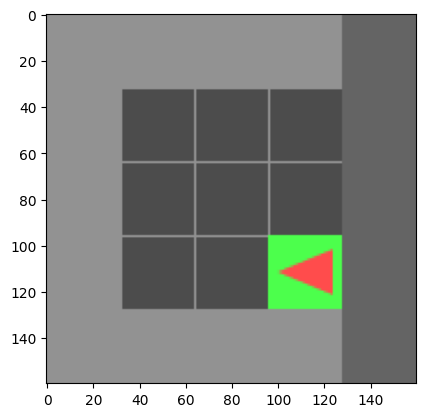

Paso 3, accion 3, x: 2, y 2, dir 2


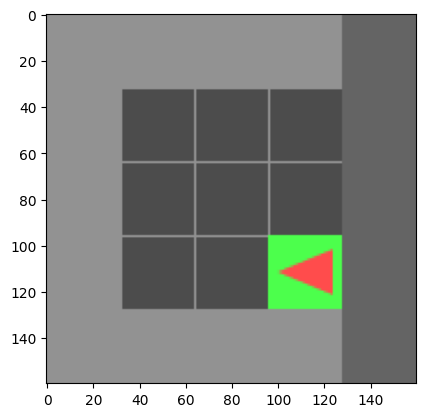

Paso 4, accion 2, x: 1, y 2, dir 2


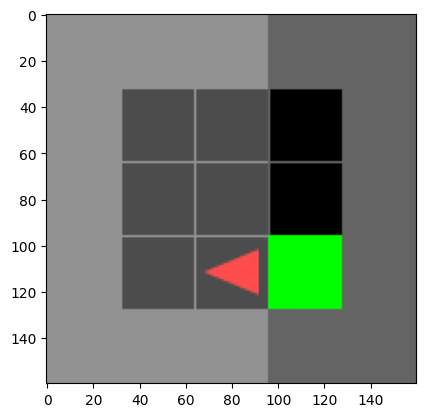

Paso 5, accion 2, x: 0, y 2, dir 2


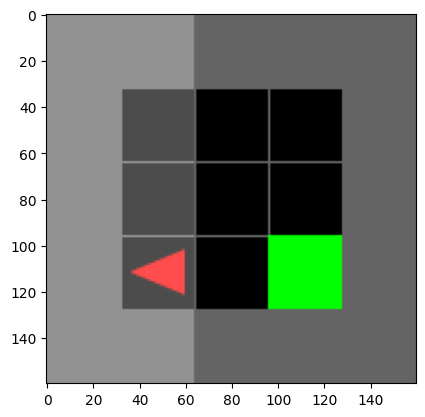

Paso 6, accion 3, x: 0, y 2, dir 2


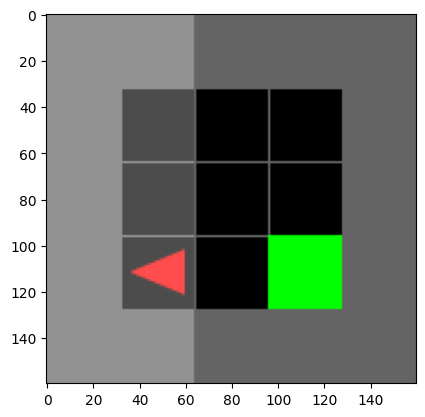

Paso 7, accion 1, x: 0, y 2, dir 3


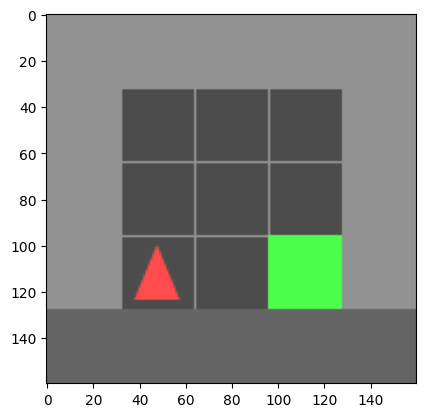

Paso 8, accion 0, x: 0, y 2, dir 2


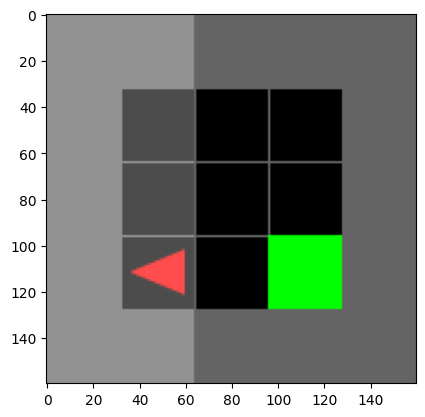

Paso 9, accion 4, x: 0, y 2, dir 2


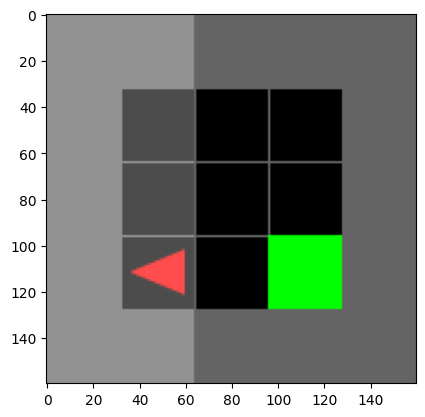

Paso 10, accion 2, x: 0, y 2, dir 2


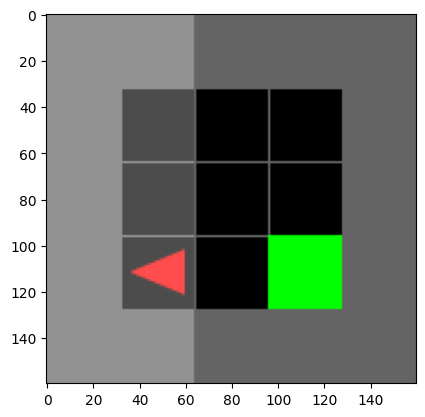

Paso 11, accion 0, x: 0, y 2, dir 1


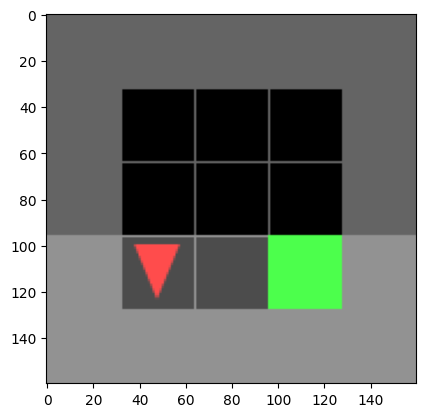

Paso 12, accion 6, x: 0, y 2, dir 1


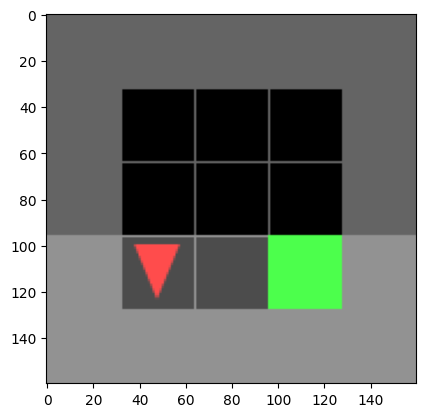

Paso 13, accion 5, x: 0, y 2, dir 1


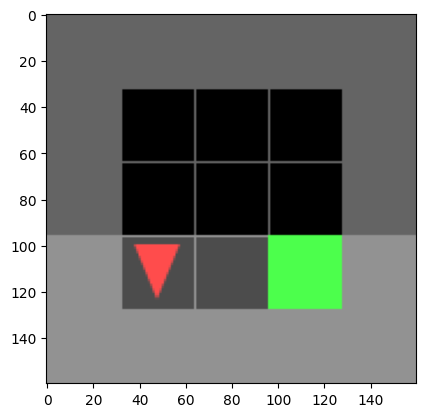

Paso 14, accion 4, x: 0, y 2, dir 1


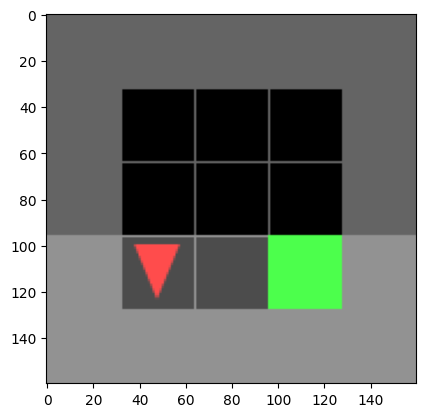

Paso 15, accion 5, x: 0, y 2, dir 1


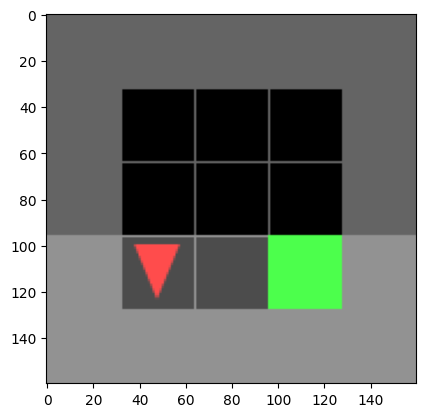

Paso 16, accion 4, x: 0, y 2, dir 1


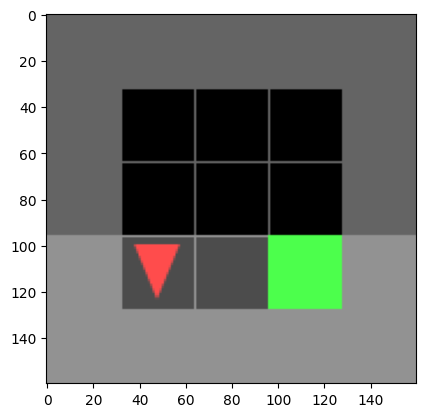

Paso 17, accion 2, x: 0, y 2, dir 1


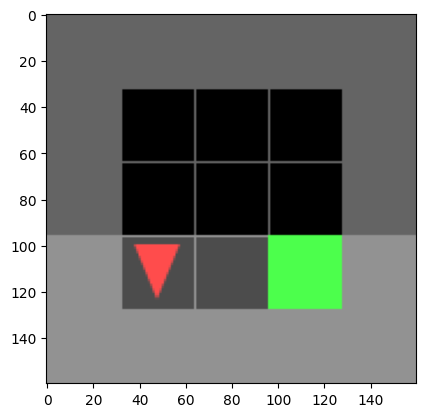

Paso 18, accion 3, x: 0, y 2, dir 1


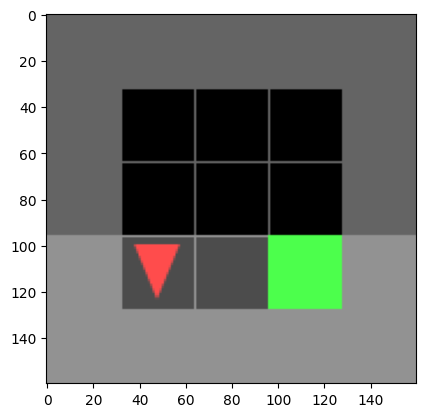

Paso 19, accion 6, x: 0, y 2, dir 1


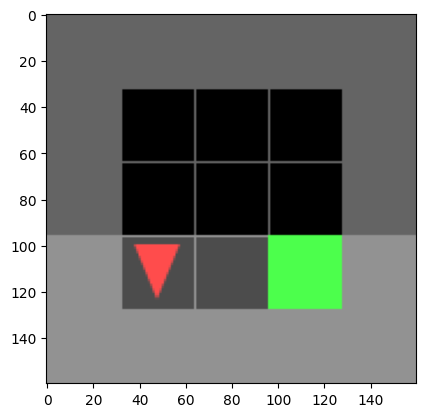

Paso 20, accion 4, x: 0, y 2, dir 1


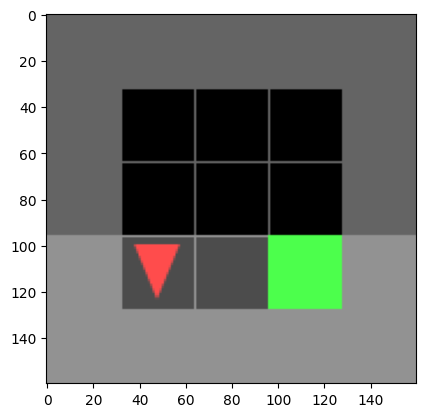

Paso 21, accion 3, x: 0, y 2, dir 1


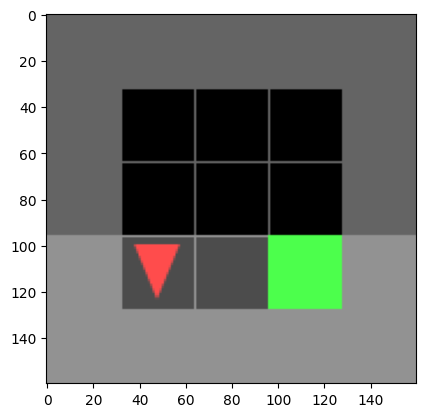

Paso 22, accion 1, x: 0, y 2, dir 2


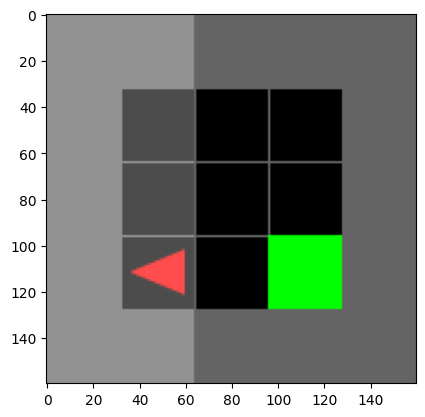

Paso 23, accion 1, x: 0, y 2, dir 3


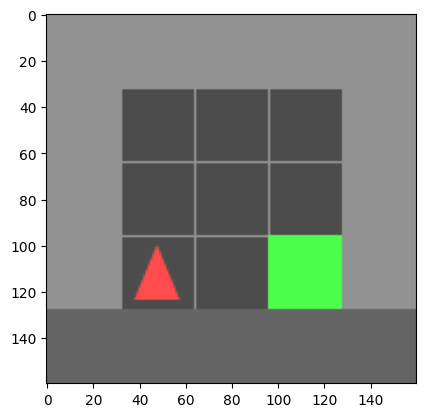

Paso 24, accion 4, x: 0, y 2, dir 3


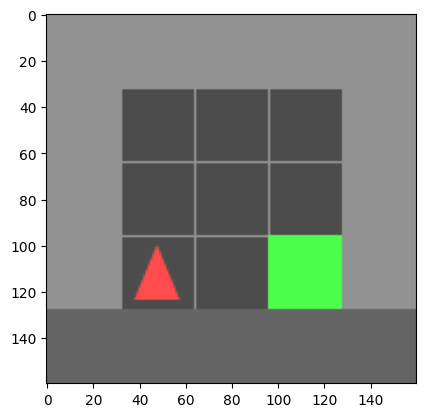

Paso 25, accion 2, x: 0, y 1, dir 3


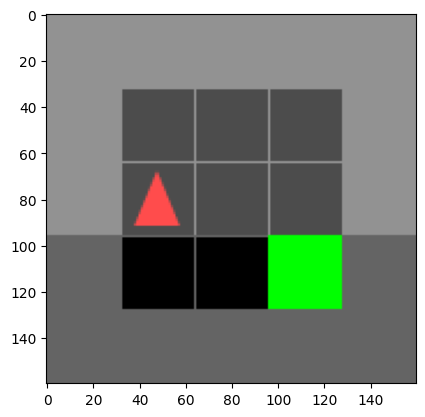

Paso 26, accion 1, x: 0, y 1, dir 0


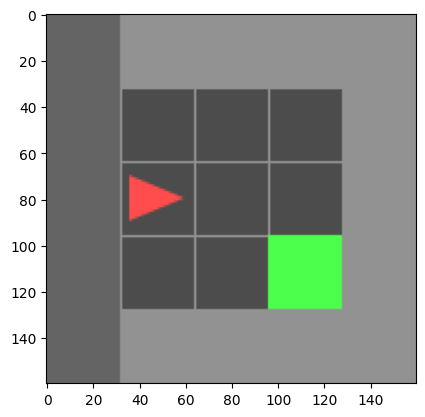

Paso 27, accion 1, x: 0, y 1, dir 1


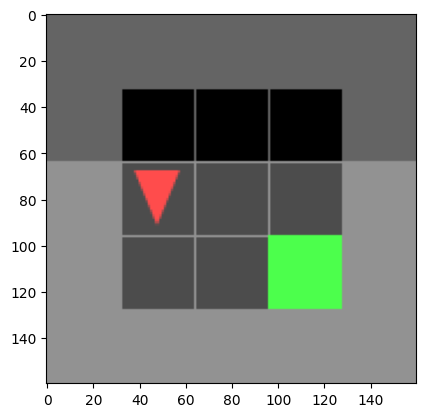

Paso 28, accion 5, x: 0, y 1, dir 1


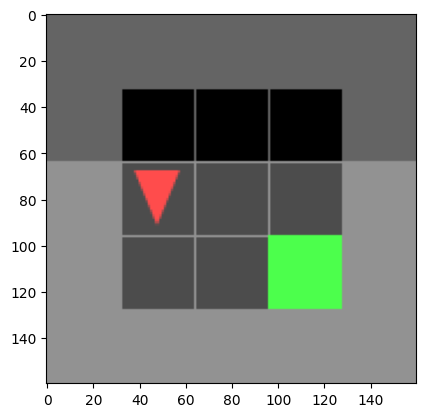

Paso 29, accion 5, x: 0, y 1, dir 1


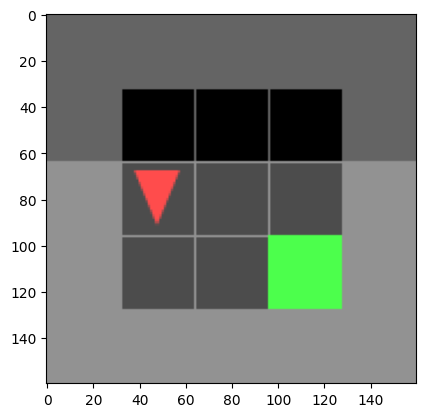

Paso 30, accion 5, x: 0, y 1, dir 1


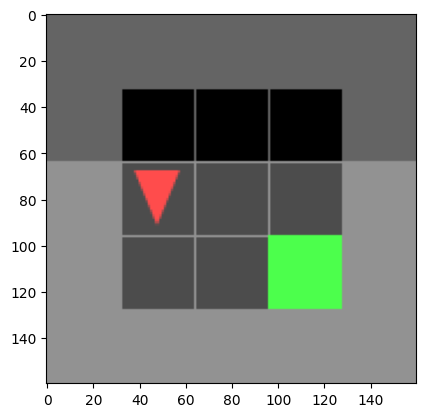

Paso 31, accion 1, x: 0, y 1, dir 2


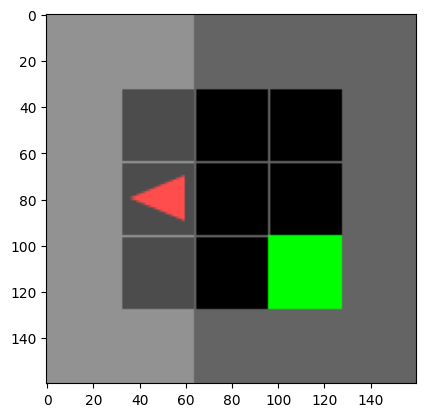

Paso 32, accion 1, x: 0, y 1, dir 3


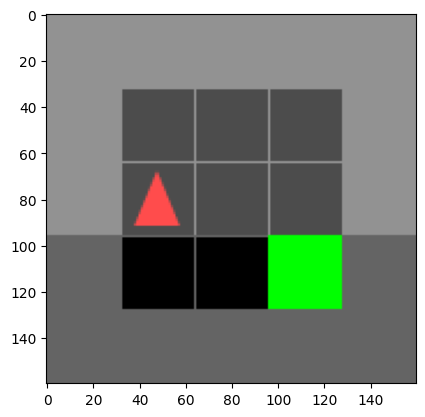

Paso 33, accion 1, x: 0, y 1, dir 0


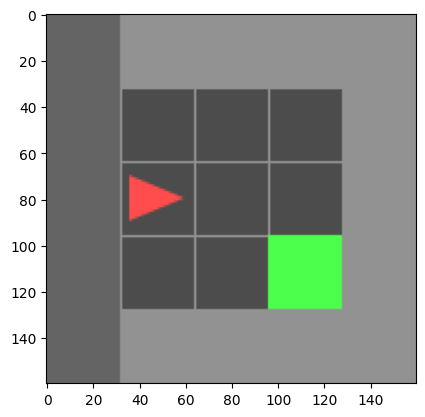

Paso 34, accion 6, x: 0, y 1, dir 0


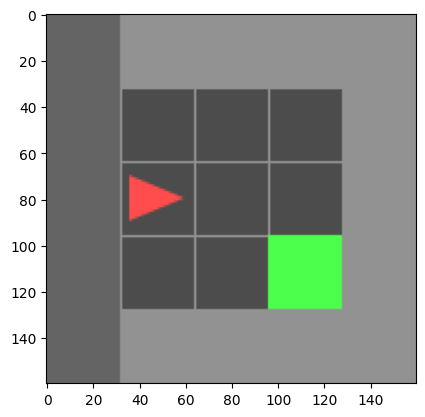

Paso 35, accion 0, x: 0, y 1, dir 3


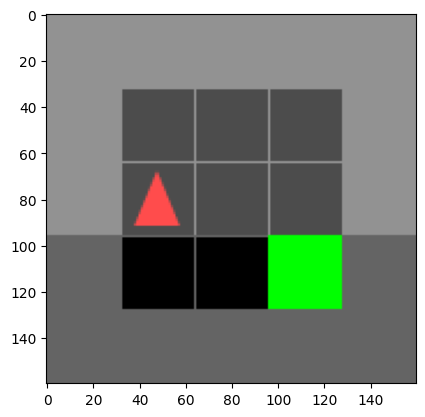

Paso 36, accion 2, x: 0, y 0, dir 3


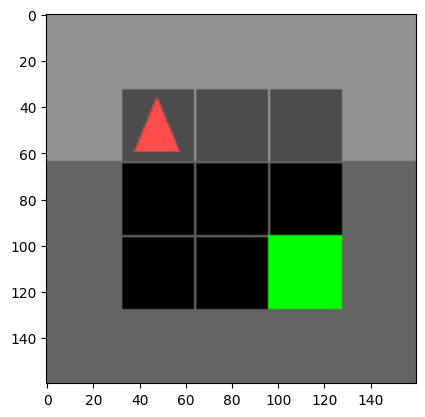

Paso 37, accion 2, x: 0, y 0, dir 3


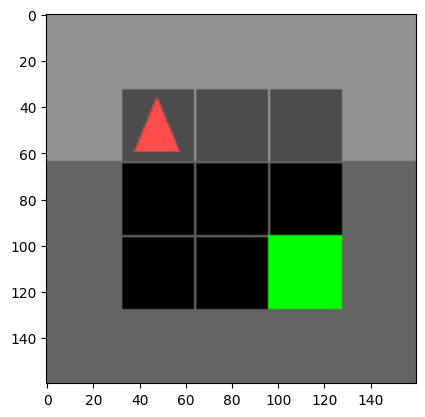

Paso 38, accion 1, x: 0, y 0, dir 0


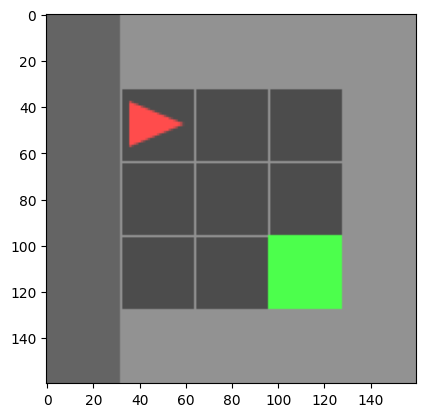

Paso 39, accion 1, x: 0, y 0, dir 1


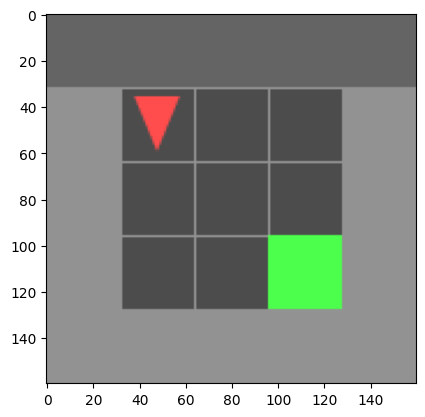

Paso 40, accion 0, x: 0, y 0, dir 0


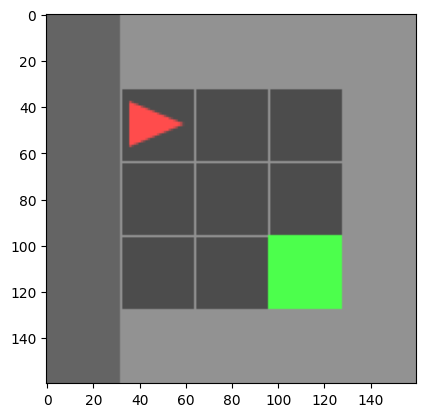

Paso 41, accion 4, x: 0, y 0, dir 0


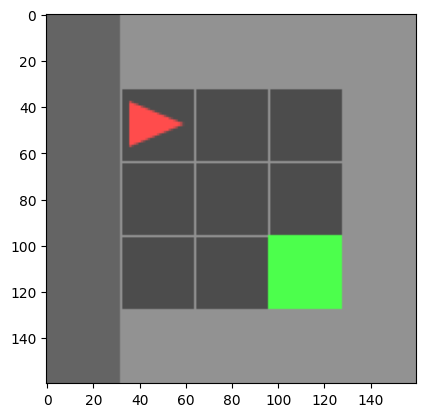

Paso 42, accion 2, x: 1, y 0, dir 0


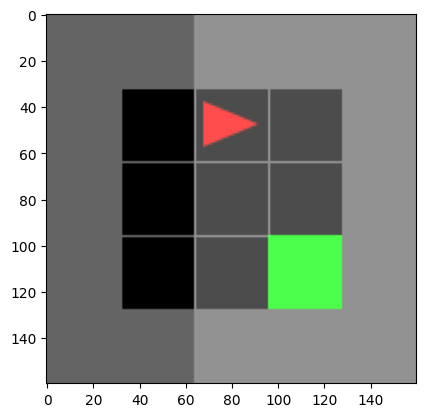

Paso 43, accion 0, x: 1, y 0, dir 3


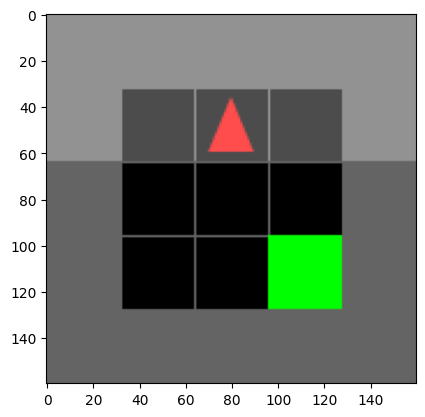

Paso 44, accion 6, x: 1, y 0, dir 3


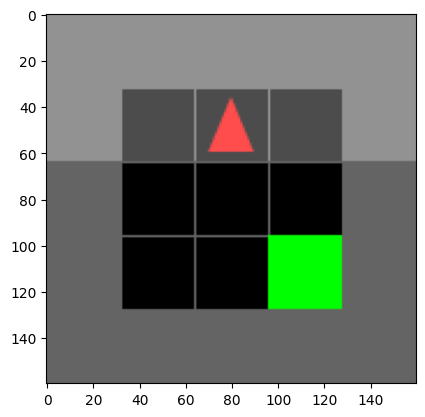

Paso 45, accion 2, x: 1, y 0, dir 3


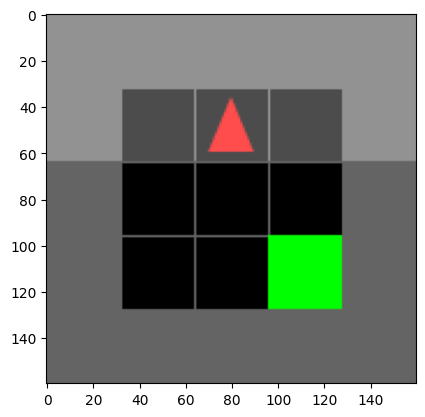

Paso 46, accion 2, x: 1, y 0, dir 3


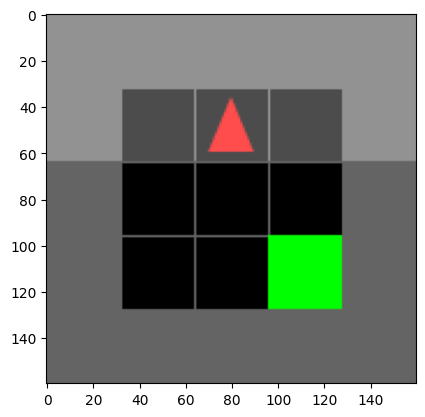

Paso 47, accion 6, x: 1, y 0, dir 3


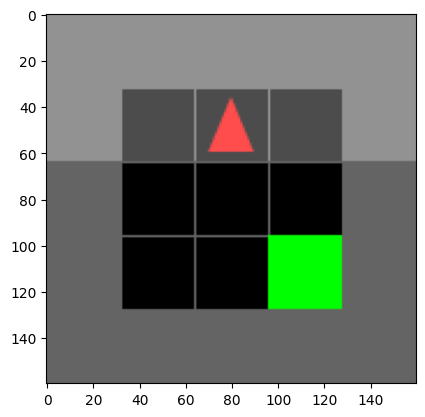

Paso 48, accion 0, x: 1, y 0, dir 2


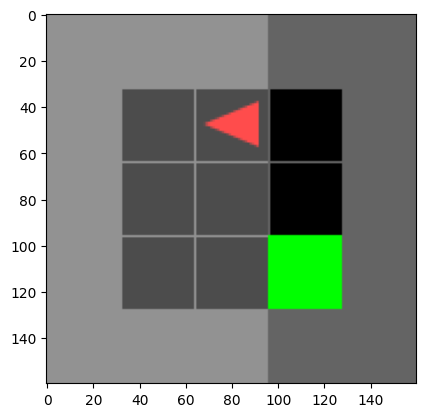

Paso 49, accion 2, x: 0, y 0, dir 2


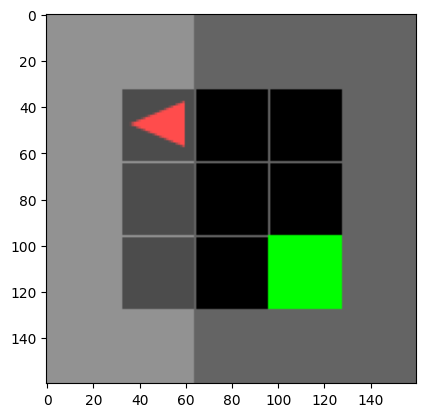

Paso 50, accion 3, x: 0, y 0, dir 2


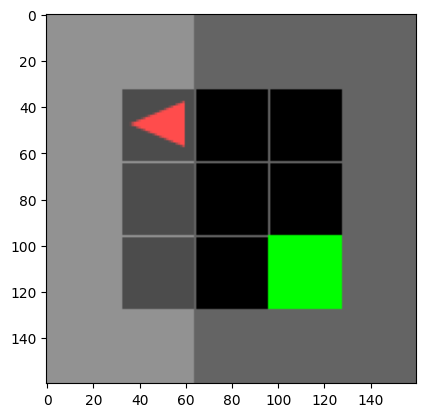

Paso 51, accion 0, x: 0, y 0, dir 1


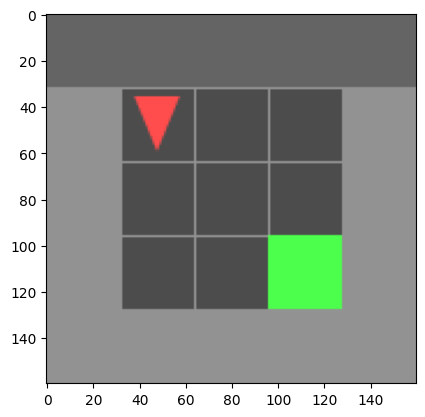

Paso 52, accion 1, x: 0, y 0, dir 2


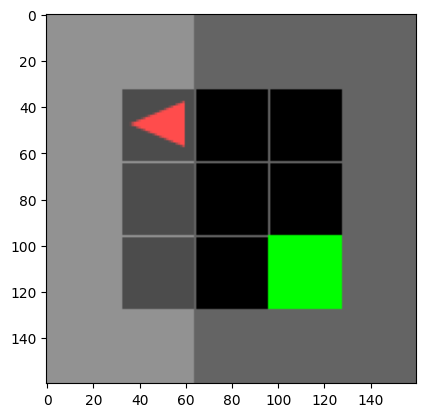

Paso 53, accion 6, x: 0, y 0, dir 2


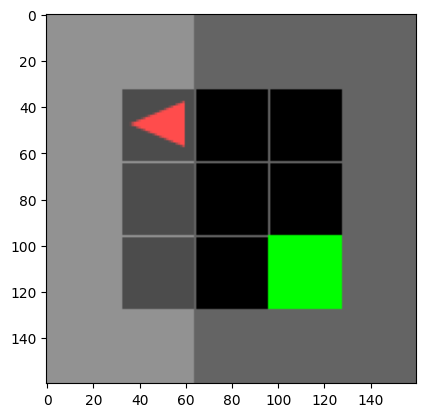

Paso 54, accion 5, x: 0, y 0, dir 2


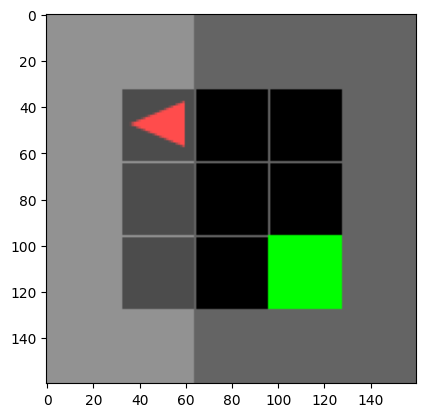

Paso 55, accion 0, x: 0, y 0, dir 1


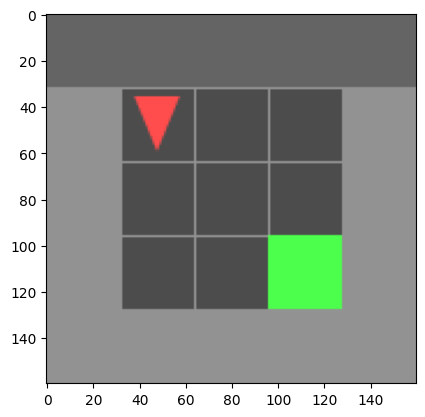

Paso 56, accion 2, x: 0, y 1, dir 1


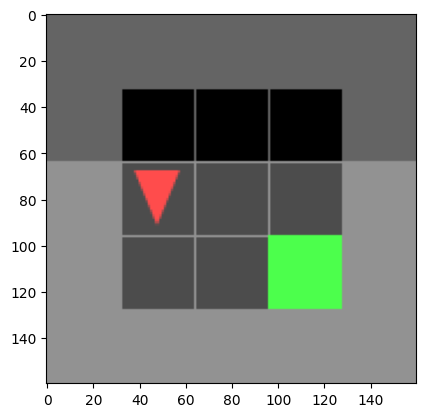

Paso 57, accion 4, x: 0, y 1, dir 1


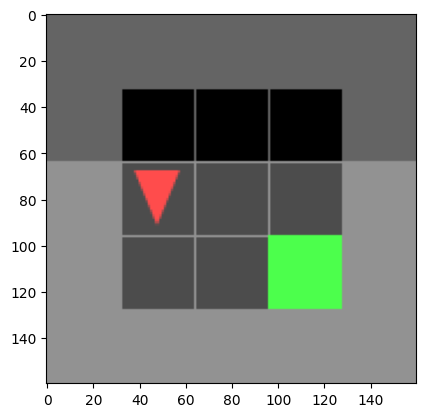

Paso 58, accion 0, x: 0, y 1, dir 0


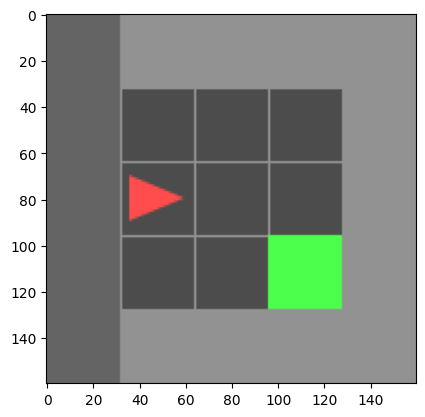

Paso 59, accion 0, x: 0, y 1, dir 3


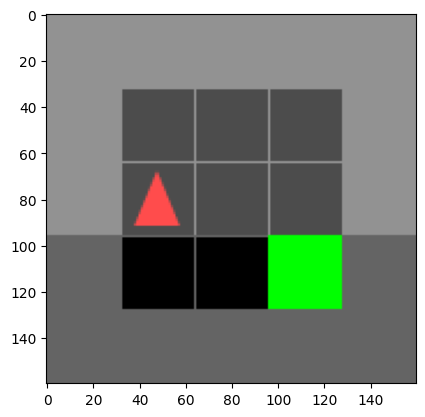

Paso 60, accion 5, x: 0, y 1, dir 3


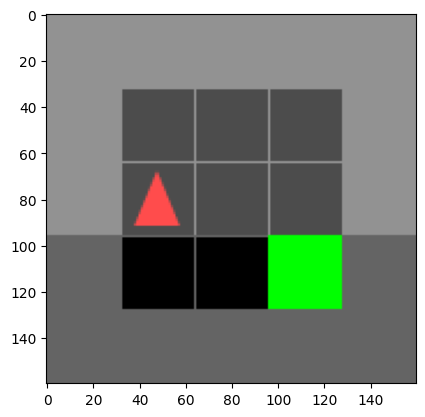

Paso 61, accion 0, x: 0, y 1, dir 2


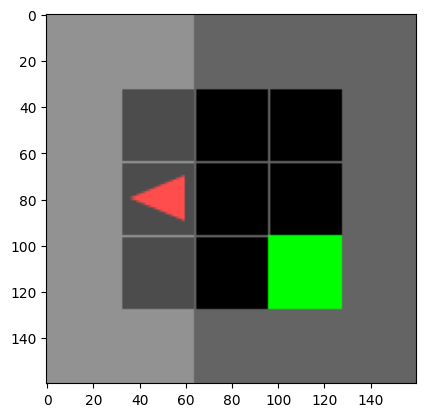

Paso 62, accion 0, x: 0, y 1, dir 1


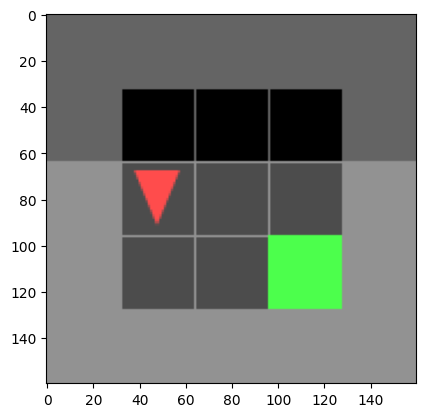

Paso 63, accion 3, x: 0, y 1, dir 1


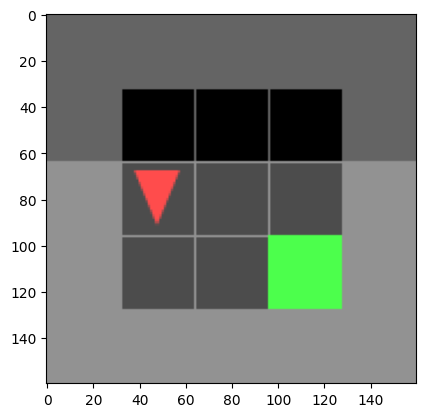

Paso 64, accion 2, x: 0, y 2, dir 1


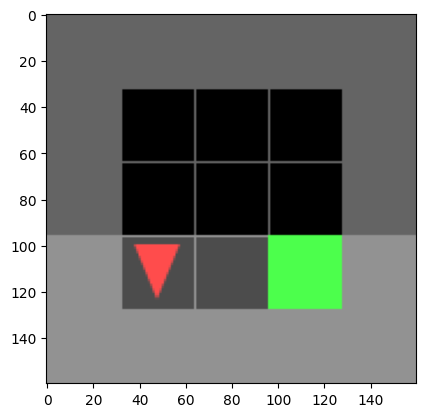

Paso 65, accion 0, x: 0, y 2, dir 0


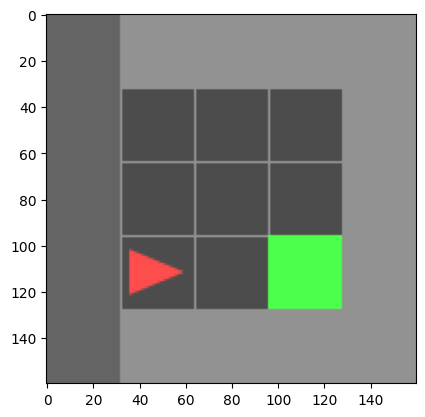

Paso 66, accion 6, x: 0, y 2, dir 0


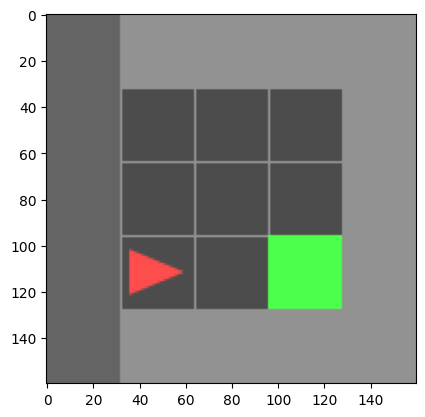

Paso 67, accion 3, x: 0, y 2, dir 0


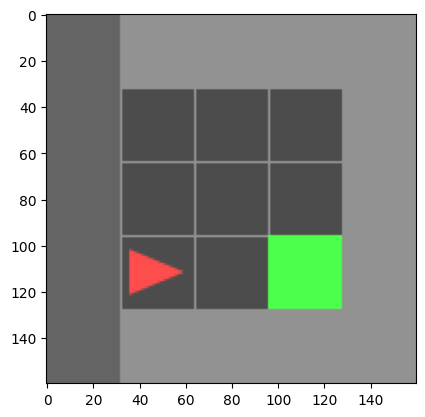

Paso 68, accion 1, x: 0, y 2, dir 1


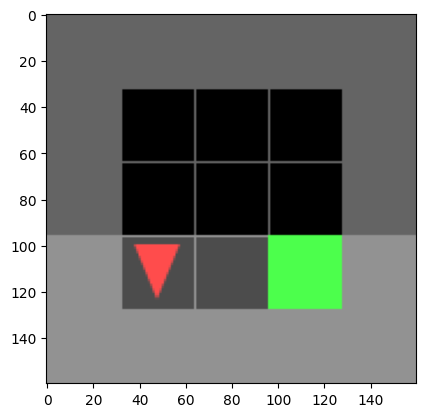

Paso 69, accion 3, x: 0, y 2, dir 1


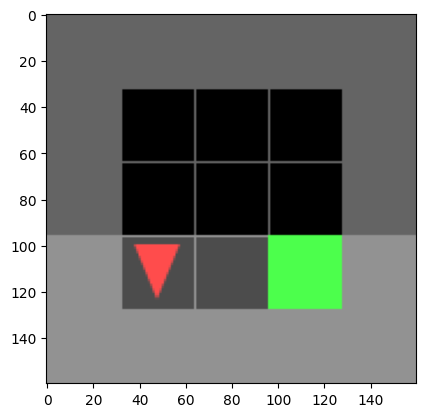

Paso 70, accion 5, x: 0, y 2, dir 1


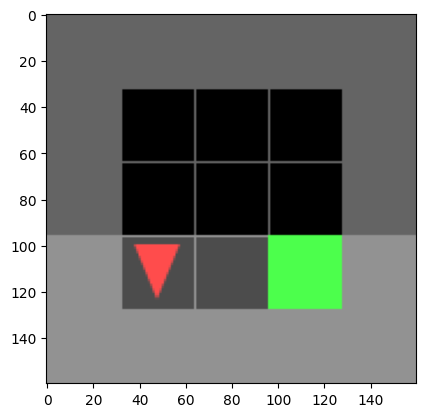

Paso 71, accion 1, x: 0, y 2, dir 2


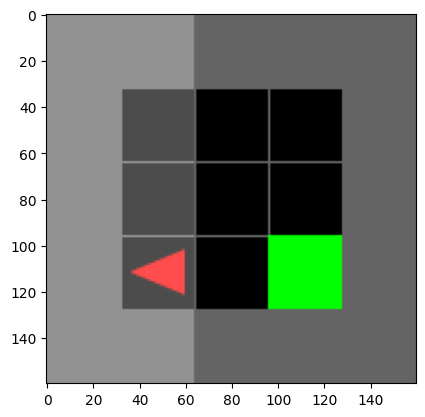

Paso 72, accion 3, x: 0, y 2, dir 2


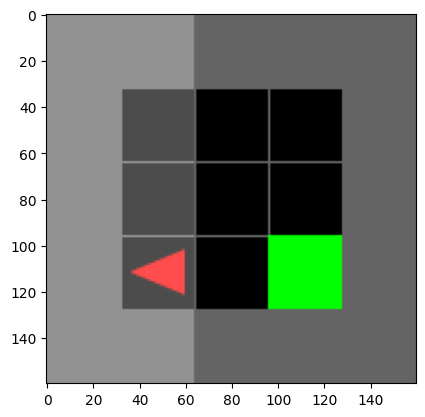

Paso 73, accion 5, x: 0, y 2, dir 2


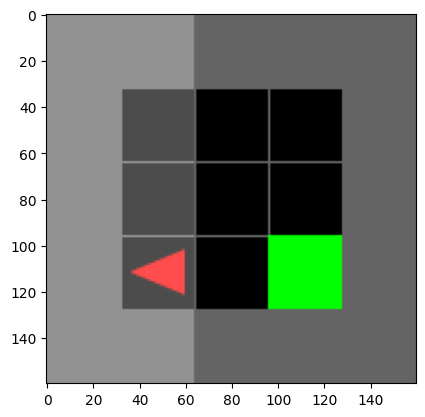

Paso 74, accion 5, x: 0, y 2, dir 2


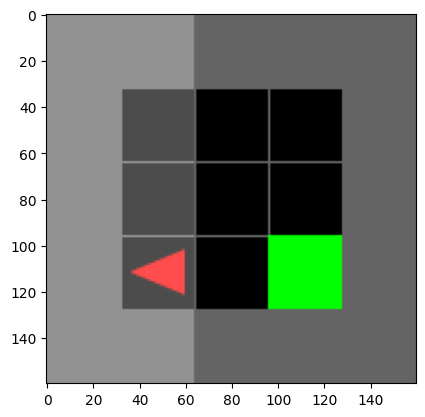

Paso 75, accion 2, x: 0, y 2, dir 2


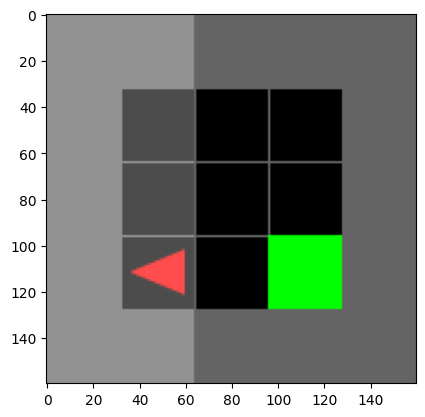

Paso 76, accion 2, x: 0, y 2, dir 2


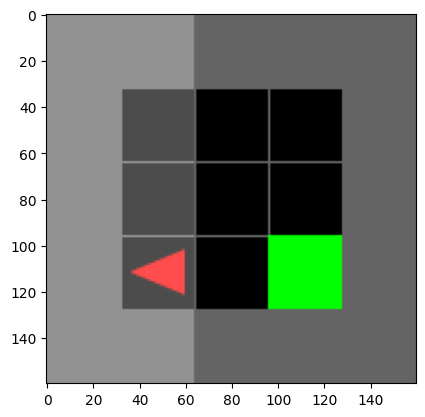

Paso 77, accion 4, x: 0, y 2, dir 2


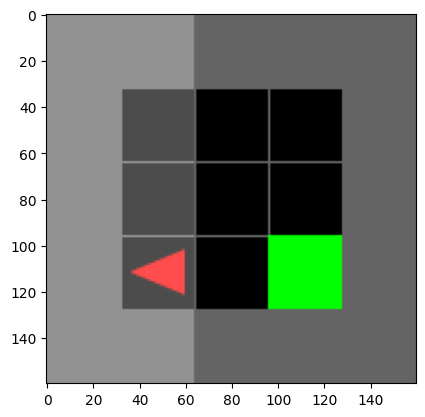

Paso 78, accion 0, x: 0, y 2, dir 1


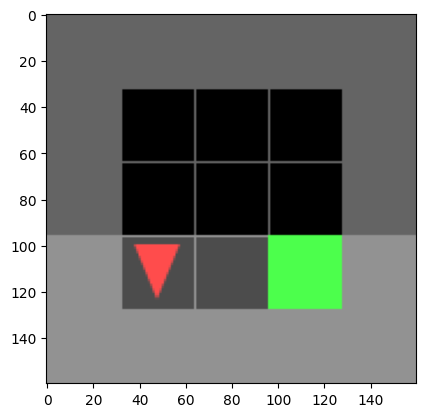

Paso 79, accion 2, x: 0, y 2, dir 1


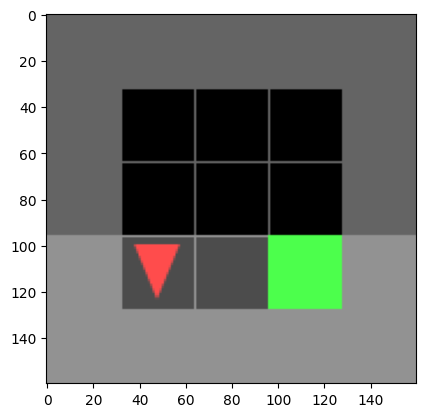

Paso 80, accion 4, x: 0, y 2, dir 1


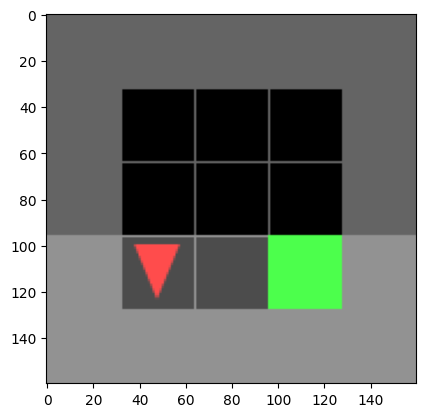

Paso 81, accion 2, x: 0, y 2, dir 1


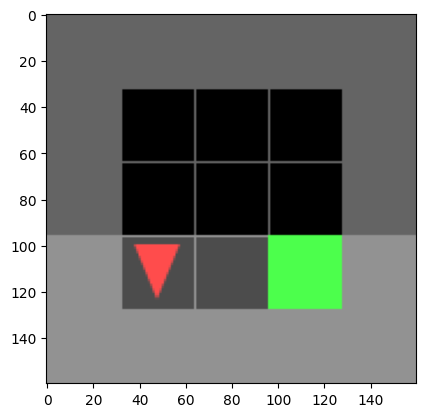

Paso 82, accion 0, x: 0, y 2, dir 0


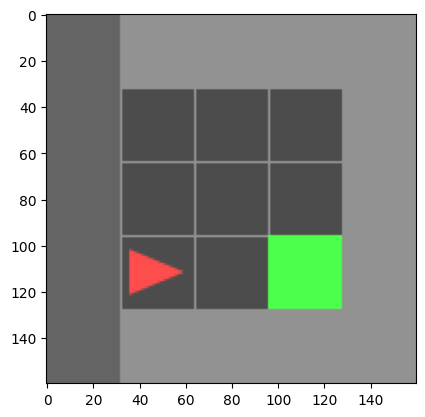

Paso 83, accion 2, x: 1, y 2, dir 0


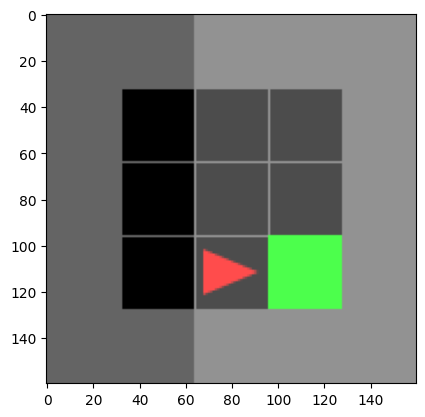

Paso 84, accion 3, x: 1, y 2, dir 0


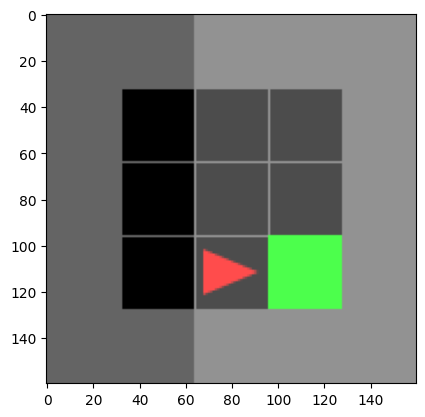

Paso 85, accion 0, x: 1, y 2, dir 3


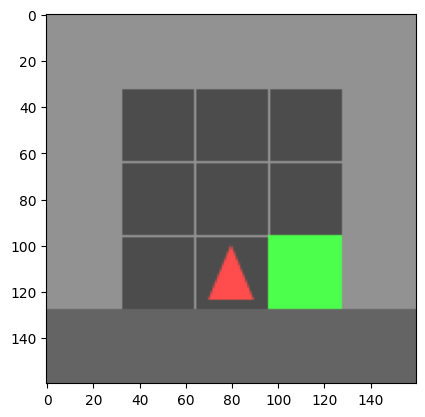

Paso 86, accion 1, x: 1, y 2, dir 0


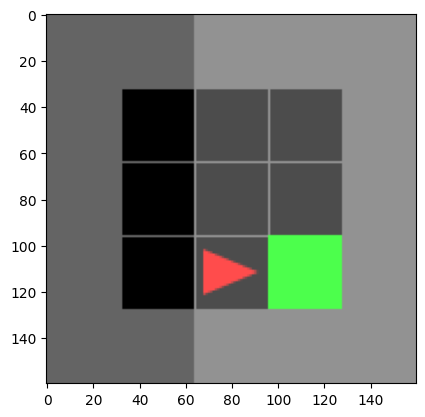

Paso 87, accion 5, x: 1, y 2, dir 0


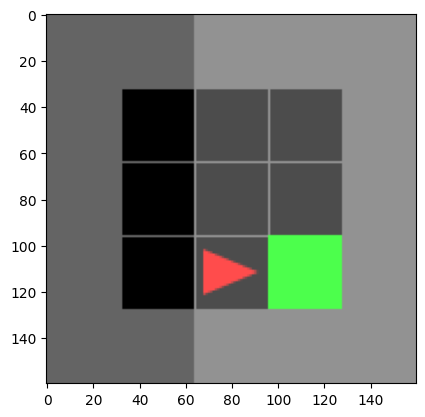

Paso 88, accion 3, x: 1, y 2, dir 0


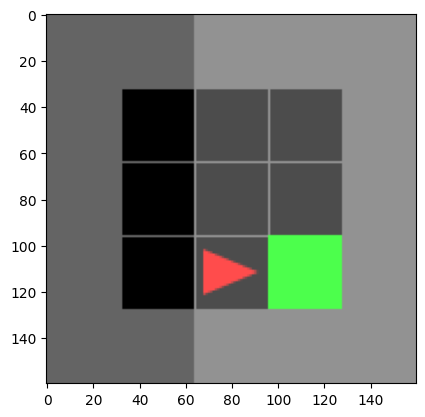

Paso 89, accion 4, x: 1, y 2, dir 0


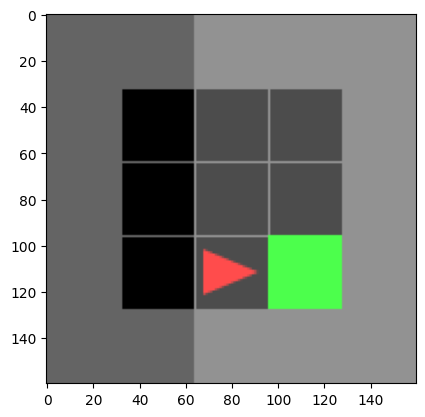

Paso 90, accion 4, x: 1, y 2, dir 0


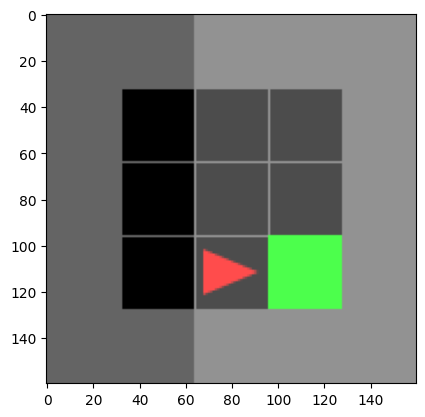

Paso 91, accion 0, x: 1, y 2, dir 3


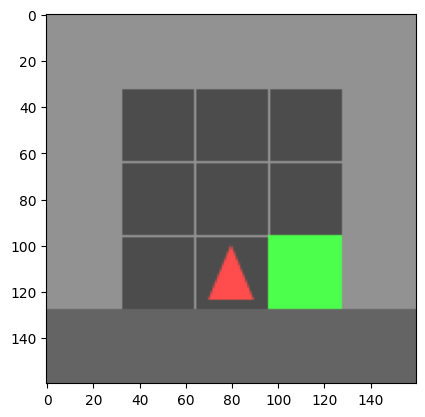

Paso 92, accion 5, x: 1, y 2, dir 3


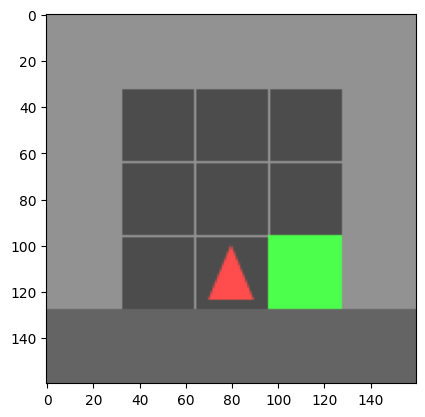

Paso 93, accion 5, x: 1, y 2, dir 3


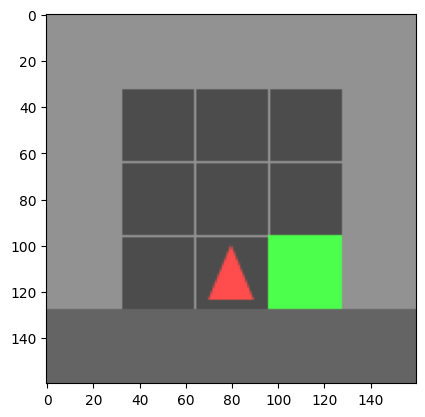

Paso 94, accion 1, x: 1, y 2, dir 0


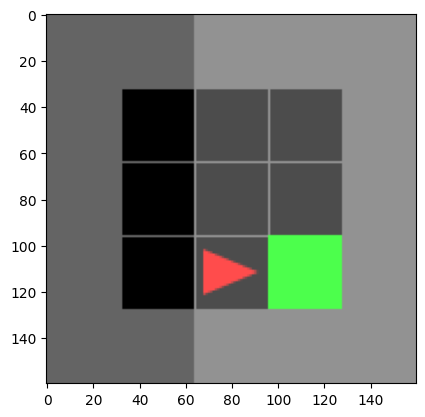

Paso 95, accion 4, x: 1, y 2, dir 0


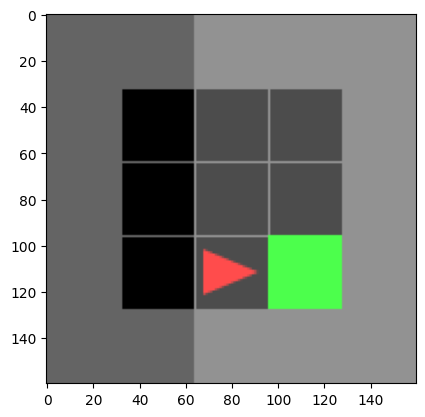

Paso 96, accion 0, x: 1, y 2, dir 3


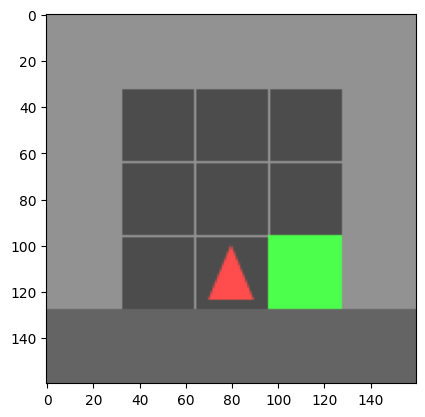

Paso 97, accion 0, x: 1, y 2, dir 2


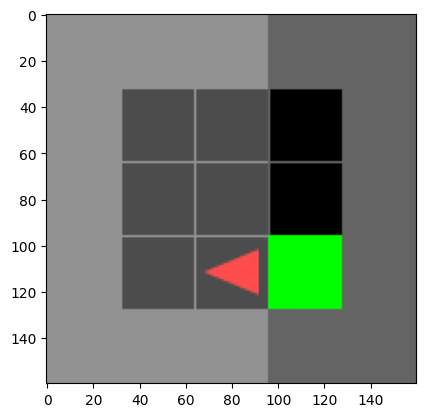

Paso 98, accion 0, x: 1, y 2, dir 1


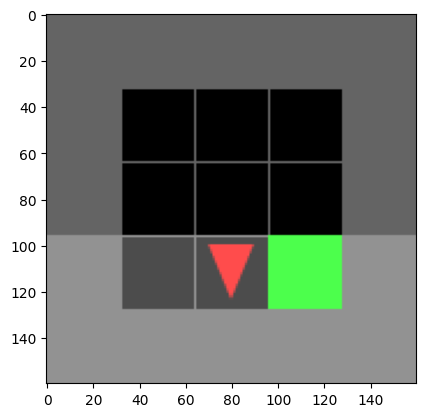

Paso 99, accion 6, x: 1, y 2, dir 1


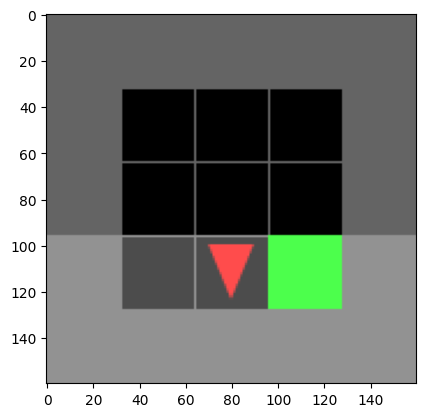

Paso 100, accion 1, x: 1, y 2, dir 2


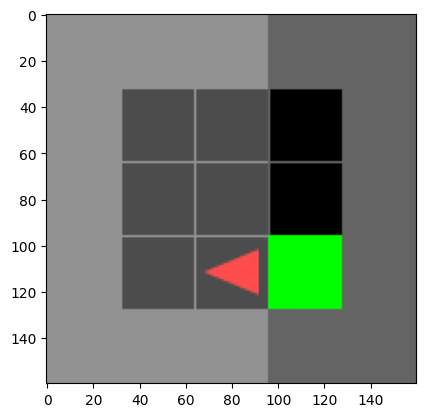

Paso 101, accion 6, x: 1, y 2, dir 2


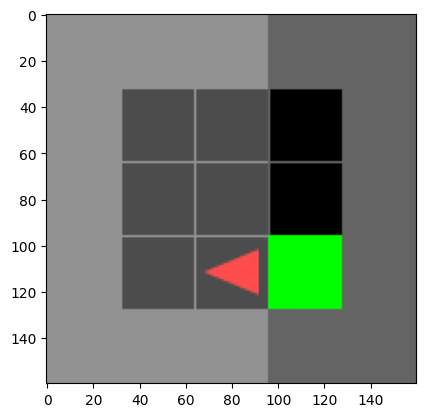

Paso 102, accion 1, x: 1, y 2, dir 3


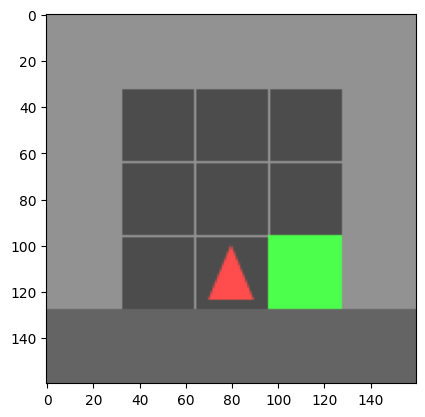

Paso 103, accion 6, x: 1, y 2, dir 3


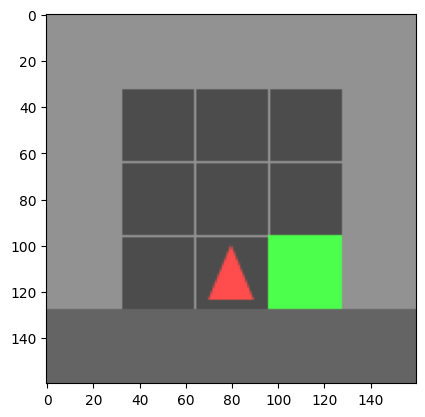

Paso 104, accion 6, x: 1, y 2, dir 3


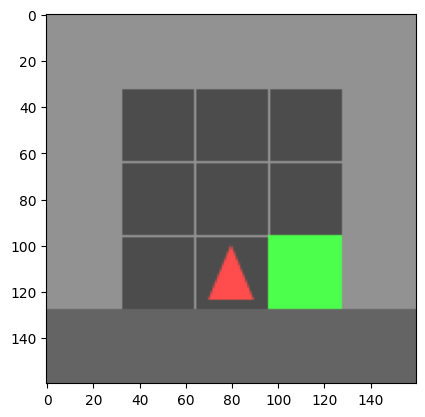

Paso 105, accion 2, x: 1, y 1, dir 3


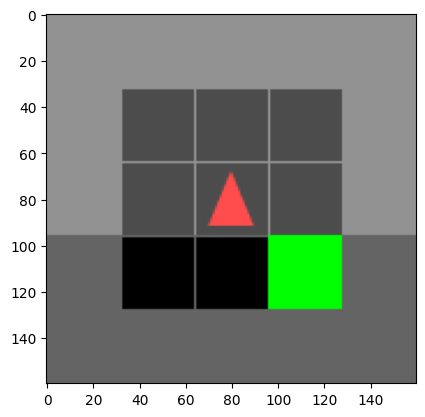

Paso 106, accion 1, x: 1, y 1, dir 0


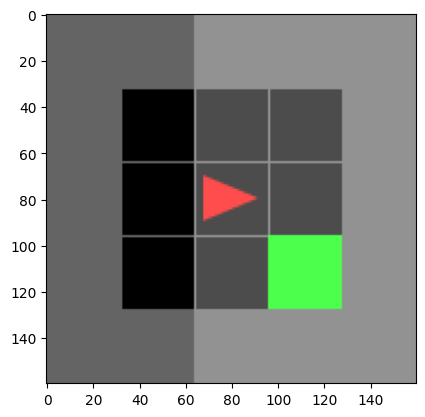

Paso 107, accion 4, x: 1, y 1, dir 0


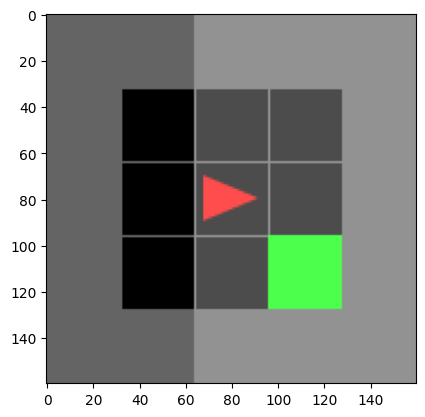

Paso 108, accion 0, x: 1, y 1, dir 3


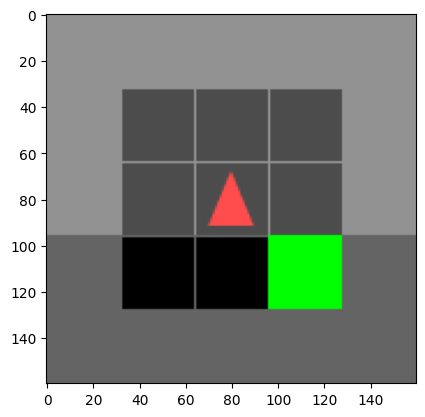

Paso 109, accion 4, x: 1, y 1, dir 3


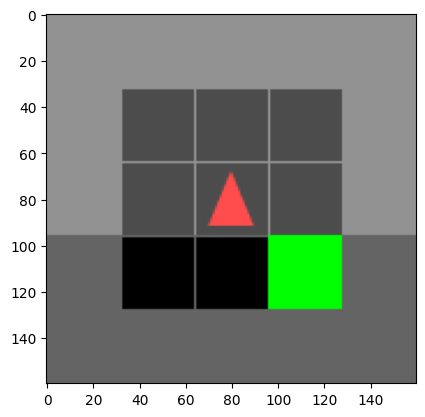

Paso 110, accion 1, x: 1, y 1, dir 0


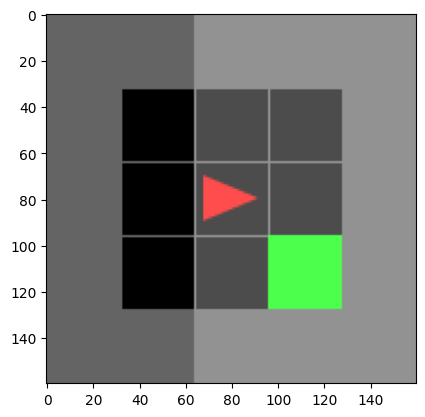

Paso 111, accion 3, x: 1, y 1, dir 0


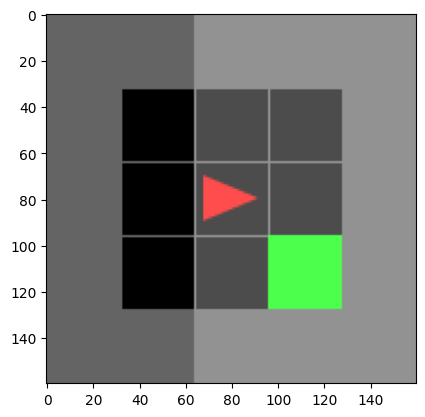

Paso 112, accion 1, x: 1, y 1, dir 1


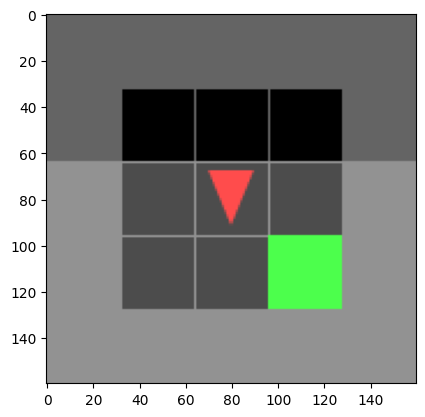

Paso 113, accion 3, x: 1, y 1, dir 1


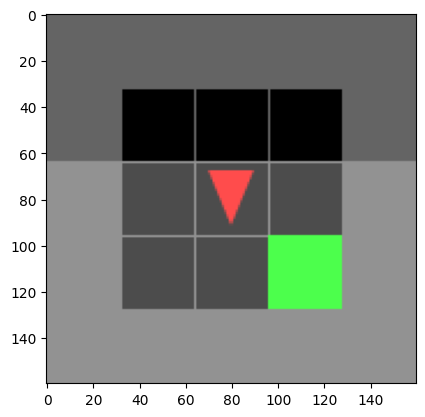

Paso 114, accion 3, x: 1, y 1, dir 1


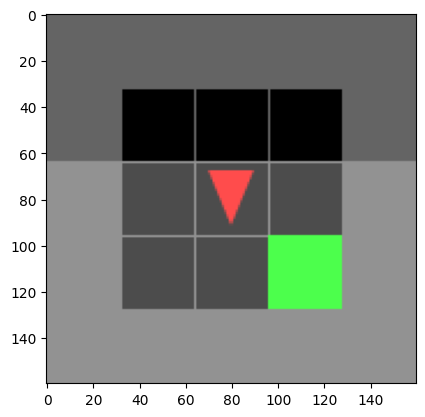

Paso 115, accion 0, x: 1, y 1, dir 0


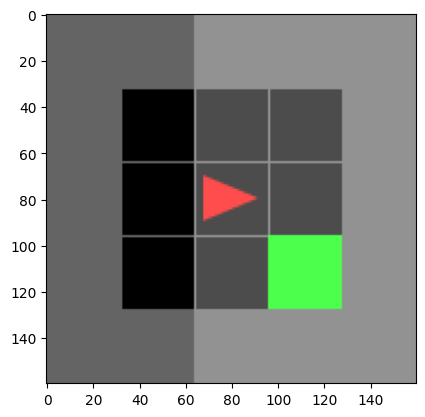

Paso 116, accion 5, x: 1, y 1, dir 0


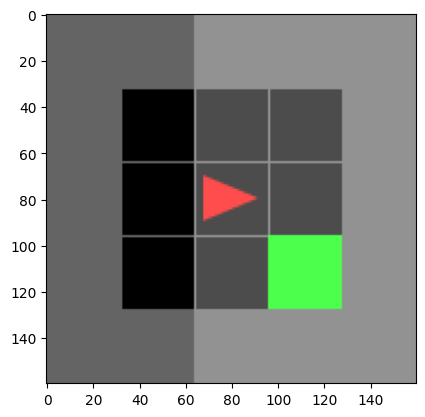

Paso 117, accion 4, x: 1, y 1, dir 0


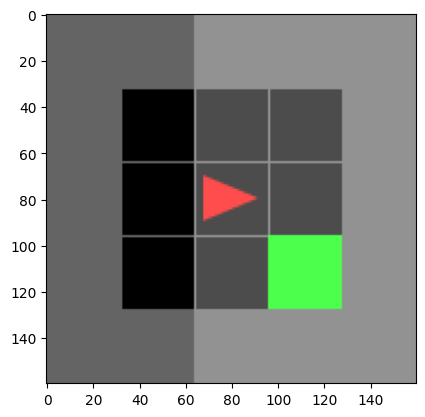

Paso 118, accion 0, x: 1, y 1, dir 3


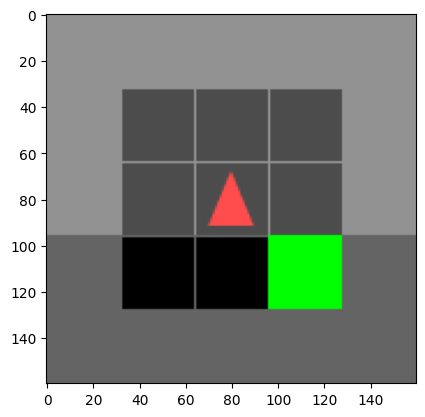

Paso 119, accion 6, x: 1, y 1, dir 3


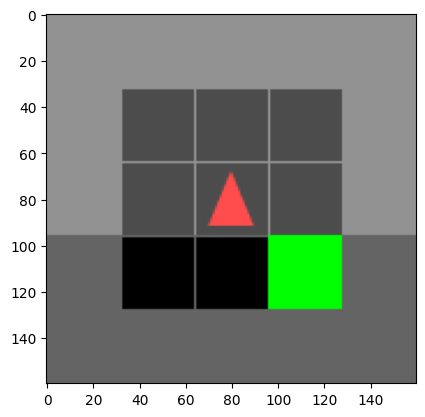

Paso 120, accion 6, x: 1, y 1, dir 3


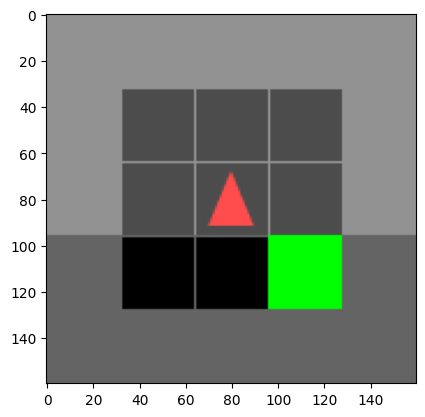

Paso 121, accion 1, x: 1, y 1, dir 0


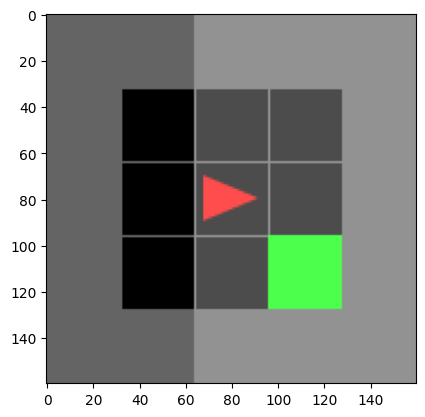

Paso 122, accion 4, x: 1, y 1, dir 0


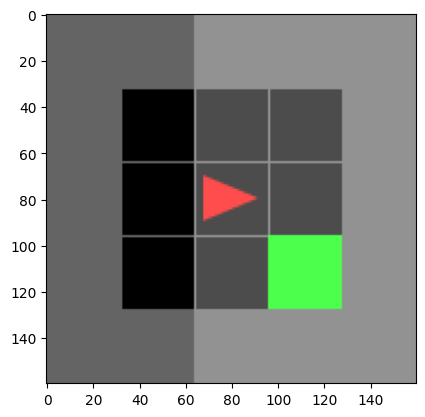

Paso 123, accion 1, x: 1, y 1, dir 1


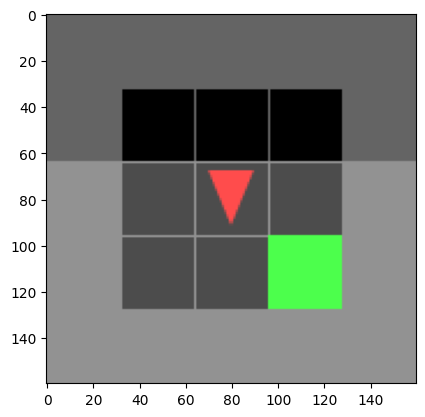

Paso 124, accion 2, x: 1, y 2, dir 1


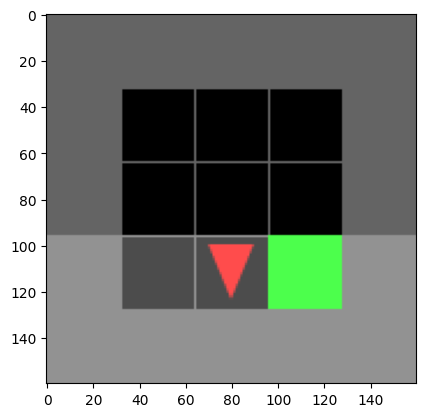

Paso 125, accion 5, x: 1, y 2, dir 1


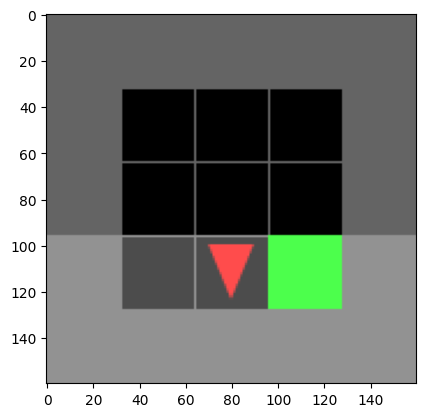

Paso 126, accion 3, x: 1, y 2, dir 1


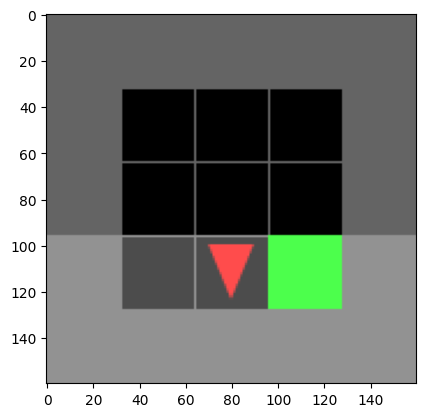

Paso 127, accion 3, x: 1, y 2, dir 1


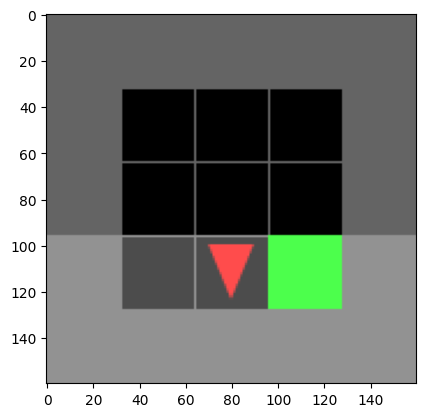

Paso 128, accion 0, x: 1, y 2, dir 0


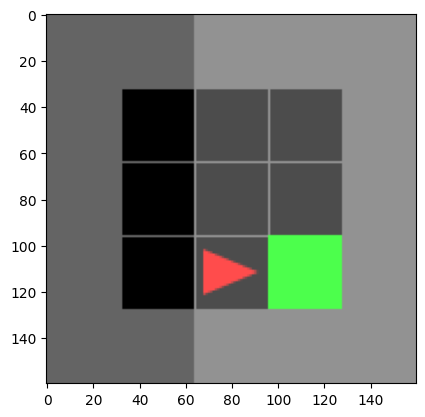

Paso 129, accion 5, x: 1, y 2, dir 0


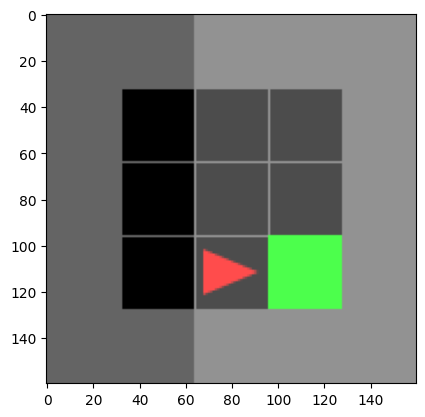

Paso 130, accion 1, x: 1, y 2, dir 1


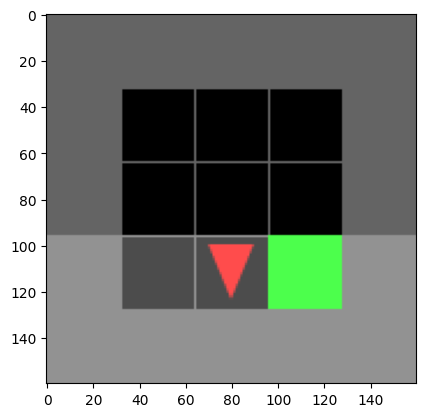

Paso 131, accion 3, x: 1, y 2, dir 1


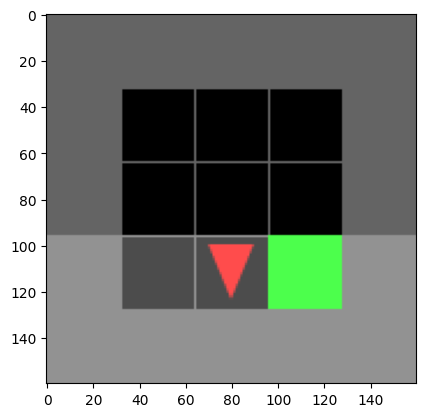

Paso 132, accion 0, x: 1, y 2, dir 0


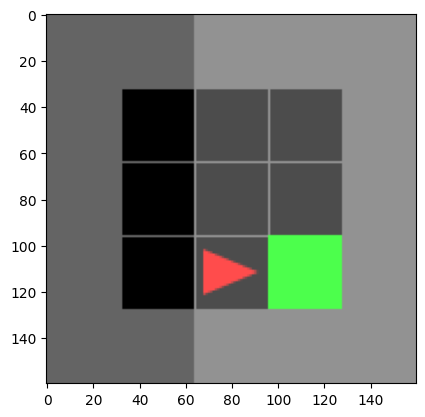

Paso 133, accion 2, x: 2, y 2, dir 0


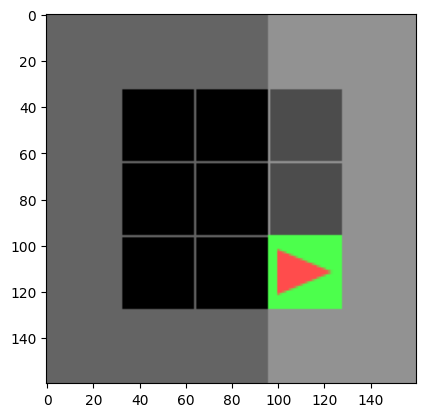

In [57]:
# Eliminamos el límite de pasos por episodio. Solo acabará el episodio al alcanzar la meta.
env.max_steps = float('inf')
print(f'Max steps modificado: {env.max_steps}')


completado = False
contador = 0
while not completado:
    # TODO - Completa el bucle
    a = env.action_space.sample()
    completado = env.step(a)[2]
    estado_actual = get_estado(env)
    print(f'Paso {contador}, accion {a}, x: {estado_actual.x}, y {estado_actual.y}, dir {estado_actual.dir}')
    im = plt.imshow(env.render())
    plt.show()
    contador+=1
    ...

### Simplificación del espacio de acciones y definición de políticas
Habrás comprobado que hay acciones que no son útiles para este problema. Vamos a simplificar la búsqueda reduciendo el espacio de acciones a tres:
 1. left
 2. right
 3. forward
 
Al hacer esto, ya no podemos generar una acción aleatoria utilizando `env.action_space.sample()`. Además, dicha función elige una acción al azar, lo cual no nos interesa. Nuestro objetivo es obtener una **política** que determine la mejor acción en cada situación, así que vamos a aprovechar el momento para definir una estructura de datos que nos permita hacer eso.

La política debe indicar una probabilidad $\pi(a|s)$ de elegir la acción $a$ estando en el estado $s$ (así que $\sum_{a'}\pi(a'|s)=1$, con $s\in \mathcal{S}$ y $a\in \mathcal{A}$). Declararemos una política como un `numpy.array` que asocie a cada estado $s$ una distribución de probabilidad sobre las distintas acciones.

La política aleatoria otorgará la misma probabilidad a todas las acciones para cada estado (como hay tres acciones, para cualquier par estado-acción la probabilidad será 1/3).

In [61]:
# Seleccionamos solo las tres acciones indicadas
ACCIONES_UTILES = [acciones.left, acciones.right, acciones.forward]


# TODO - Indica el shape de la policy
politica_aleatoria = np.zeros((3,3,4,3))
# Inicializamos todos los valores a 1/3
politica_aleatoria[:] = 1.0/3

Una vez hemos definido la política, podemos definir una función para sustituir a `env.action_space.sample()`. Esta función recibirá la política que debe seguir y el estado para el que seleccionar la acción. Devolverá la acción muestreada siguiendo la distribución descrita por la política para ese estado.

In [69]:
def muestrea_politica(estado:Estado, politica:np.ndarray) -> int:
    # Obtenemos la distribución de probabilidad
    probs = politica[estado.x, estado.y, estado.dir, :]
    # Comprobación de que la política está bien (se puede comentar cuando estemos seguros de que es así)
    np.testing.assert_almost_equal(np.sum(probs), 1.0, err_msg='La política para un estado siempre debe sumar 1')
    # Devolvemos una acción aleatoria muestreada según las probabilidades indicadas por la política
    return np.random.choice(ACCIONES_UTILES, p=probs)
    
# TODO - Obtén la acción muestreada de la policy_aleatoria para el estado en que el agente está en la casilla central mirando hacia abajo
accion = muestrea_politica(Estado(x=1,y=1,dir=0),politica_aleatoria)

print(accion)

1


### Simulación de episodios siguiendo una política prefijada
Al disponer ya de una definición para políticas y de una función de muestreo sobre cualquier política, podemos adaptar nuestro bucle que simula un episodio para que lo haga siguiendo una política concreta.

Definiremos una función llamada `simula_episodio` para ello. La función debe recibir la política a seguir y dos parámetros que nos indicarán, respectivamente, si se mostrarán los *renders* de los pasos del episodio y si se mostrarán mensajes de texto.

La función deberá devolver una tupla con el **retorno** obtenido, es decir, la suma de las recompensas recibidas en cada paso y el **número de pasos** necesarios para completar el episodio.

In [78]:
env.step(accion)

({'image': array([[[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
 

In [83]:
def simula_episodio(politica:np.ndarray, muestra_renders:bool=False, imprime:bool=False) -> tuple[float, int]:
    env.reset()
    # TODO - Adapta el bucle que escribiste 3 celdas de código más arriba para que use la política para decidir qué acción tomar en cada paso
    completado = False
    contador = 0
    ret = 0
    while not completado:
        estado_actual = get_estado(env)
        accion = muestrea_politica(estado_actual,politica)
        observacion = env.step(accion)
        completado = observacion[2]
        ret += observacion[1]
        if imprime:
            print(f'Paso {contador}, accion {accion}, x: {estado_actual.x}, y {estado_actual.y}, dir {estado_actual.dir}')
        #im = plt.imshow(env.render())
        #plt.show()
        contador+=1
    
    return (ret, contador)

retorno, num_pasos = simula_episodio(politica_aleatoria, muestra_renders=False, imprime=True)
print(f'Simulado un episodio con retorno {retorno} ({num_pasos})')

Paso 0, accion 0, x: 0, y 0, dir 0
Paso 1, accion 0, x: 0, y 0, dir 3
Paso 2, accion 0, x: 0, y 0, dir 2
Paso 3, accion 0, x: 0, y 0, dir 1
Paso 4, accion 0, x: 0, y 0, dir 0
Paso 5, accion 0, x: 0, y 0, dir 3
Paso 6, accion 1, x: 0, y 0, dir 2
Paso 7, accion 1, x: 0, y 0, dir 3
Paso 8, accion 0, x: 0, y 0, dir 0
Paso 9, accion 1, x: 0, y 0, dir 3
Paso 10, accion 1, x: 0, y 0, dir 0
Paso 11, accion 1, x: 0, y 0, dir 1
Paso 12, accion 1, x: 0, y 0, dir 2
Paso 13, accion 1, x: 0, y 0, dir 3
Paso 14, accion 2, x: 0, y 0, dir 0
Paso 15, accion 1, x: 1, y 0, dir 0
Paso 16, accion 2, x: 1, y 0, dir 1
Paso 17, accion 1, x: 1, y 1, dir 1
Paso 18, accion 0, x: 1, y 1, dir 2
Paso 19, accion 0, x: 1, y 1, dir 1
Paso 20, accion 2, x: 1, y 1, dir 0
Paso 21, accion 0, x: 2, y 1, dir 0
Paso 22, accion 0, x: 2, y 1, dir 3
Paso 23, accion 0, x: 2, y 1, dir 2
Paso 24, accion 2, x: 2, y 1, dir 1
Simulado un episodio con retorno 0.775 (25)


### Comprobación del rendimiento de la política

Hagamos un experimento para evaluar la eficacia de la política aleatoria. Simularemos 200 episodios, anotando el número de pasos necesarios para completar cada uno. No es necesario que llevemos cuenta de los retornos obtenidos porque en este problema siempre será 1 (dado que solo la última acción da recompensa, con valor 1).

Mostraremos estadísticas y gráficos que nos puedan ayudar a tener una idea de cómo de bien funciona.

0 - Simulado un episodio con retorno 0.3969999999999999 (67)
1 - Simulado un episodio con retorno 0.721 (31)
2 - Simulado un episodio con retorno 0.07299999999999995 (103)
3 - Simulado un episodio con retorno -0.5569999999999999 (173)
4 - Simulado un episodio con retorno 0.838 (18)
5 - Simulado un episodio con retorno 0.379 (69)
6 - Simulado un episodio con retorno 0.5680000000000001 (48)
7 - Simulado un episodio con retorno 0.73 (30)
8 - Simulado un episodio con retorno 0.82 (20)
9 - Simulado un episodio con retorno -0.19700000000000006 (133)
10 - Simulado un episodio con retorno 0.703 (33)
11 - Simulado un episodio con retorno 0.9369999999999999 (7)
12 - Simulado un episodio con retorno 0.253 (83)
13 - Simulado un episodio con retorno -0.10699999999999998 (123)
14 - Simulado un episodio con retorno 0.8109999999999999 (21)
15 - Simulado un episodio con retorno 0.45999999999999996 (60)
16 - Simulado un episodio con retorno 0.2799999999999999 (80)
17 - Simulado un episodio con retorno 0

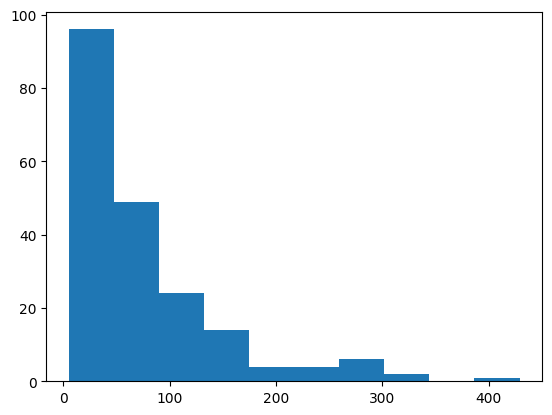

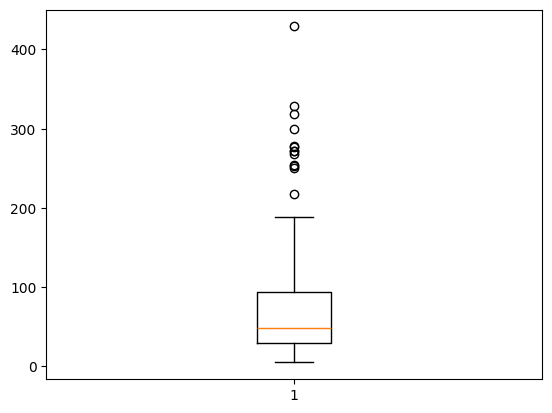

Se han necesitado de media 74.485 pasos (+- 71.17063843327527 )
El episodio más corto duró 5 pasos y el episodio más largo duró 429 pasos


In [84]:
def comprueba_politica(politica:np.ndarray) -> None:
    # TODO - Simula 200 episodios, añadiendo sus respectivos números de pasos a episodios_pasos y mostrando por cada uno un mensaje de la forma '{iteracion} - Simulado un episodio con retorno {retorno} ({num_pasos})'
    episodios_pasos = []
    for i in range(200):
        retorno, num_pasos = simula_episodio(politica_aleatoria, imprime=False)
        episodios_pasos.append(num_pasos)
        print(f'{i} - Simulado un episodio con retorno {retorno} ({num_pasos})')
   

    assert(len(episodios_pasos)==200)
    
    # Mostramos un histograma para la duración de los episodios
    plt.hist(episodios_pasos)
    plt.show()

    # Mostramos también un diagrama de caja
    plt.boxplot(episodios_pasos)
    plt.show()

    # Por último, escribimos un par de estadísticas
    print('Se han necesitado de media',np.mean(episodios_pasos),'pasos (+-',np.std(episodios_pasos),')')
    print('El episodio más corto duró',np.min(episodios_pasos),'pasos y el episodio más largo duró',np.max(episodios_pasos),'pasos')
    
comprueba_politica(politica_aleatoria)

# Obtención de políticas óptimas
## Métodos de programación dinámica

A la hora de encontrar una política óptima que guíe las acciones de nuestro agente, los métodos basados en programación dinámica son una buena opción cuando disponemos de conocimento respecto a las dinámicas del entorno.

En particular, estos métodos requieren conocer $p(s',r | s,a)$, es decir, la probabilidad de acabar en un estado $s'$ recibiendo una recompensa $r$ si aplicamos la acción $a$ al estado $s$.

OpenGym no nos proporciona esta información, pero en este problema sencillo podemos reconstruirla. Este entorno es determinista, lo que quiere decir que si aplicamos la acción $a$ al estado $s$ siempre obtendremos el mismo estado $s'$ y la misma recompensa $r$ con probabilidad 1 (cualquier otro estado $s_j$ o recompensa $r_j$ tendrán $p(s_j,r_j|s,a)=0$).

Podemos, por tanto, representar el modelo con dos variables:
 - `modelo_transiciones`: Para cada combinación $s,a$, almacena el estado $s'$ al que conduce aplicar la acción $a$ a $s$.
 - `modelo_recompensas`: Para cada combinación $s,a$, almacena el valor de la recompensa obtenida al aplicar la acción $a$ a $s$.
 
Sabiendo cómo se comporta el entorno, definimos estas dos variables con los valores adecuados.

In [ ]:
# DEFINICIÓN DEL MODELO

# Modelo de transiciones - Almacena a qué estado lleva aplicar cada acción a cada estado
# Lo almacenamos en un array numpy en el que para cada estado almacenemos, para cada acción, el estado al que lleva.
modelo_transiciones = np.zeros((3,3,4,3,3),dtype=np.int16)
# Recorremos cada estado para completar el estado al que lleva cada una de las tres acciones posibles
for i in range(3): # Columnas (x)
    for j in range(3): # Filas (y)
        for k in range(4): # Orientaciones (dir)
            # Aplicar la acción left gira el agente a la izquierda, así que el estado resultante tendrá el mismo valor para filas y columnas pero variará la orientación
            modelo_transiciones[i,j,k,0]=[i,j,(k+4-1)%4]
            # Aplicar la acción right gira el agente a la derecha, así que el estado resultante tendrá el mismo valor para filas y columnas pero variará la orientación
            modelo_transiciones[i,j,k,1]=[i,j,(k+1)%4]
        # Aplicar la acción forward mantiene la orientación, pero cambia filas o columnas en función de hacia dónde esté orientado
        if i<2:
            modelo_transiciones[i,j,0,2]=[i+1,j,0] # Derecha
        if j<2:
            modelo_transiciones[i,j,1,2]=[i,j+1,1] # Abajo
        if i>0:
            modelo_transiciones[i,j,2,2]=[i-1,j,2] # Izquierda
        if j>0:
            modelo_transiciones[i,j,3,2]=[i,j-1,3] # Arriba

# Modelo de transiciones - Almacena qué recompensa proporciona aplicar cada acción a cada estado
# Lo almacenamos en un array numpy en el que para cada estado almacenemos, para cada acción, la recompensa.
modelo_recompensas = np.zeros((3,3,4,3))
# Será 0 siempre menos en dos casos:
# 1 - Está en la segunda columna de la tercera fila, orientado a la derecha y se usa la acción forward
modelo_recompensas[1,2,0,2] = 1
# 2 - Está en la tercera columna de la segunda fila, orientado hacia abajo y se usa la acción forward
modelo_recompensas[2,1,1,2] = 1

# Función auxiliar para consultar los estados a los que lleva cada acción para un estado dado
def get_resultados_por_accion_en(estado: Estado) -> list[Estado]:
    valores_estados_para_cada_accion = modelo_transiciones[estado.x, estado.y, estado.dir]
    return list(map(lambda x: Estado(*x), valores_estados_para_cada_accion))

# Función auxiliar para consultar las recompensas de aplicar cada acción en un estado dado
def get_recompensas_por_accion_en(estado: Estado) -> np.ndarray:
    # TODO - Completa la función
    return modelo_recompensas[estado.x, estado.y, estado.dir]

# TODO - Muestra los estados resultantes y las recompensas de aplicar las distintas acciones cuando el agente está en la tercera casilla de la segunda fila, orientado hacia abajo y se ejecuta la acción forward
...
...

## Algoritmo 1: Evaluación de políticas iterativa
El algoritmo de evaluación de políticas iterativa calcula el valor $v_\pi(s)$ para todo estado $s$ siguiendo la política $\pi$. La fórmula que utiliza, que está basada en la ecuación de Bellman para $v_\pi(s)$, es esta:

$$v_\pi(s)=\mathbb{E}_\pi [R_{t+1}+\gamma v_k(S_{t+1}) | S_t=s]$$

$$=\sum_a\pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma v_k(s')]$$

Al ser este un problema determinista, la expresión se simplifica, dado que $p(s',r|s,a)$ será 0 en todos los casos menos en 1 (porque aplicar la acción $a$ al estado $s$ conduce siempre a un estado $s'$ fijo y único y otorga siempre una recompensa $r$ fija y única; ambos valores los podemos obtener del modelo).

Puedes ver el algoritmo al completo aquí:

![Evaluación de políticas iterativa](https://github.com/eirasf/GCED-AA3/blob/main/lab4/img/iterative-policy-evaluation.png?raw=true)

Implementemos el algoritmo para obtener los valores asignados a cada estado siguiendo una política fija.

**CONSEJO: Para asegurar la convergencia, actualiza todos los valores de $V_{t+1}(s)$ a partir de los valores $V_t(s)$, es decir, crea una variable `nuevos_valores_estados` donde almacenes todos los calculados en una iteración y al completar la iteración establece `valores_estados = nuevos_valores_estados`**

In [ ]:
GAMMA = 0.1

def iterative_policy_evaluation(politica: np.ndarray) ->np.ndarray:
    THETA = 0.00001
    
    # En esta variable almacenaremos los valores calculados para los estados
    # TODO - Indica el shape adecuado. Debes almacenar un valor por cada estado posible
    valores_estados = np.zeros(...)
    
    # TODO - Completa el algoritmo según lo descrito arriba
    ...
    return valores_estados

valores_estados = iterative_policy_evaluation(politica_aleatoria)
print(valores_estados)

# COMPROBACIÓN
np.testing.assert_almost_equal(valores_estados[0,0,1], 4.11522634e-07)

### Optimización de políticas

En el apartado anterior hemos obtenido un valor para cada estado del problema cuando se sigue la política $\pi$;  podemos utilizar estos valores para encontrar una nueva política $\pi'$ que sea igual o mejor que $\pi$.

Cuando disponemos de $v_\pi(s)$ y del modelo que describe el funcionamiento del entorno, podemos obtener una política $\pi'\geq\pi$ simplemente seleccionando, para cada estado, la acción que nos da un mayor retorno, que podemos calcular como la recompensa inmediata más el valor del estado al que llegamos (descontado por $\gamma$).

$$\pi'(s)=\arg\max_a\sum_{s',r}p(s',r|s,a)\left[r+\gamma v_\pi(s')\right]$$

Escribamos un algoritmo que obtenga $\pi'$ a partir de `state_values`.

In [ ]:
def crea_politica_avara(valores_estados: np.ndarray) -> np.ndarray:
    nueva_shape = list(valores_estados.shape)
    nueva_shape.append(3)
    # TODO - Indica la shape apropiada. Por cada par estado-acción debemos almacenar la probabilidad que da esta política de tomar esa acción estando en dicho estado
    # Como la política es determinista, para un estado concreto todas las acciones tendrán probabilidad 0 menos una que tendrá probabilidad 1
    politica = np.zeros(...)
    # TODO - Haz bucles anidados para recorrer todos los estados
    ...
                # Ahora para este estado debemos calcular, para todas las acciones a, G=(r + GAMMA*state_values[s[0],s[1],s[2]]) donde r es la recompensa de aplicar a y s es el estado resultante.
                # De todos esos valores, tomaremos el mejor (supongamos que es el i-ésimo) y pondremos probabilidad 1 en la acción i-ésima para dicho estado.
                # TODO - Recorre las acciones, calculando su G. Selecciona el mejor y pon a 1 la probabilidad de la acción correspondiente.
                ...
    return politica

politica_mejorada = crea_politica_avara(valores_estados)

# COMPROBACIÓN
assert(np.array_equal(politica_mejorada[2,1,1],[0., 0., 1.]))

## Obtención de la política óptima - Policy iteration
Ahora que podemos evaluar una política y, a partir de esos valores, obtener una política mejorada, podemos repetir el proceso para seguir mejorando nuestra política hasta que no cambie. Este procedimiento se denomina *policy iteration* y lo tienes aquí descrito:

![Policy iteration](https://github.com/eirasf/GCED-AA3/blob/main/lab4/img/policy-iteration.png?raw=true)

Implementémoslo (la mayoría ya lo tenemos hecho).

In [ ]:
def policy_iteration(politica_inicial: np.ndarray) -> np.ndarray:
    politica_actual = politica_inicial
    politica_estable = False
    # Llevaremos cuenta del paso en que estamos
    paso = 0
    while not politica_estable:
        # TODO - Calcula los valores para current_policy
        valores_actuales = ...
        # TODO - Obtén la nueva política mejorada a partir de los valores calculados
        nueva_politica = ...
        # Comprobamos si la política ha cambiado
        politica_estable = np.array_equal(politica_actual, nueva_politica)
        # Preparamos la siguiente iteración
        politica_actual = nueva_politica
        paso+=1
        print('Paso #',paso)
    # Al terminar el bucle habremos obtenido una política que ya no mejora
    return politica_actual
        
politica_optima = policy_iteration(politica_aleatoria)
print(politica_optima)

# COMPROBACIÓN
assert(np.array_equal(politica_optima[2,0,1], [0., 0., 1.]))

Comprobemos que la política obtenida funciona bien simulando un episodio siguiéndola.

In [ ]:
simula_episodio(politica_optima, muestra_renders=True, imprime=True)

## Obtención de la política óptima - Iteración de valores
El proceso de iteración de políticas es costoso porque requiere hacer una estimación iterativa de $v_\pi(s)$ para todas las políticas por las que se pasa. Este proceso se puede simplificar y obtener una política óptima siguiendo el algoritmo de iteración de valores:

![Value iteration](https://github.com/eirasf/GCED-AA3/blob/main/lab4/img/value-iteration.png?raw=true)

El algoritmo es muy similar al de evaluación de políticas iterativas. La diferencia es que, en lugar de calcular $\mathbb{E}_\pi [R_{t+1}+\gamma v_k(S_{t+1}) | S_t=s]$, se toma el valor de la mejor acción. Al final, se devuelve la política greedy derivada de los valores calculados. Implementémoslo.

In [ ]:
def value_iteration() -> np.ndarray: # No recibe ningún parámetro. Calcula valores y política a partir del modelo del entorno.
    # TODO - Repite el algoritmo de evaluación de políticas iterativa pero tomando el G de la mejor acción para cada estado
    # Una vez tengas los state_values, devuelve la política derivada de ellos
    ...

otra_optima = value_iteration()
print(otra_optima)

# COMPROBACIÓN
assert(np.array_equal(otra_optima[2,0,1], [0., 0., 1.]))

Para terminar, comprobemos que la política obtenida así también funciona bien.

In [ ]:
simula_episodio(otra_optima, muestra_renders=True, imprime=True)
env.close() # Cerramos, además, el entorno